### Udacity Data Analysis Nanodegree
### Project 5: Communicate data findings
---

# Part II - Airline on-time performance - Exploration
## by Juanita Smith


- [Introduction](#intro)
- [Data gathering](#getdata)
- [Feature Engineering](#featureeng)
- [Step 1: Univariate Exploration](#univariate)
  - [Numerical exploration](#univariate_numerical)
  - [Time series exploration](#univariate_timeseries)
  - [Categorical exploration](#univariate_categorical)
- [Step 2: Bivariate Exploratoin](#bivariate)
  - [Numerical exploration](#bivariate_numerical)
  - [Categorical exploration](#bivariate_categorical)  
  - [Time series exploration](#bivariate_timeseries)
- [Step 3: Multivariate Exploratoin](#multivariate)
- [Conclusions](#conclusions)
- [References](#references)
- [Submission](#submission)

<a id='intro'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Introduction</span>

#### Have you ever been stuck in an airport because your flight was delayed or cancelled and wondered if you could have predicted it if you'd had more data? This is our chance to find out!

> This dataset reports flights in the United States, including carriers, arrival and departure delays, with reasons for delays, from 1987 to 2008. Due to large data volume, only years 2003 - 2008 will analysed in this project.
> - See more information about the data from the data expo challenge in 2009 [here](https://community.amstat.org/jointscsg-section/dataexpo/dataexpo2009).
> - See a full description of the features [here](https://www.transtats.bts.gov/DatabaseInfo.asp?QO_VQ=EFD&Yv0x=D.)
> - Data can be downloaded from [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7).

This analysis will be focused on **predicting flight delays**

### Dictionary:
1) Year: 1987-2008 
2) Month: 1-12 
3) DayofMonth: 1-31 
4) DayOfWeek: 1 (Monday) - 7 (Sunday) 
5) DepTime: actual departure time from gate (local, hhmm) 
6) CRSDepTime: scheduled departure time from gate (local, hhmm) 
7) ArrTime: actual arrival time at gate (local, hhmm) 
8) CRSArrTime: scheduled arrival time at date (local, hhmm) 
9) UniqueCarrier: unique carrier code 
10) FlightNum: flight number 
11) TailNum: plane tail number 
12) ActualElapsedTime: The time computed from gate departure time to gate arrival time in minutes
13) CRSElapsedTime: The time computed from gate departure time to gate arrival time in minutes
14) AirTime: in minutes 
15) ArrDelay: arrival delay, in minutes 
16) DepDelay: departure delay, in minutes 
17) Origin: origin IATA airport code 
18) Destination: IATA airport code 
19) Distance: in miles 
20) TaxiIn: The time elapsed between wheels down and arrival at the destination airport gate in minutes
21) TaxiOut: The time elapsed between departure from the origin airport gate and wheels off in minutes
22) Cancelled: 1 = yes, 0 = no 
23) CancellationCode: reason for cancellation (A = carrier, B = weather, C = NAS, D = security) 
24) Diverted: 1 = yes, 0 = no 
25) CarrierDelay: subcategory of arrDelay in minutes
26) WeatherDelay: subcategory of arrDelay in minutes 
27) NASDelay: subcategory of arrDelay in minutes 
28) SecurityDelay: subcategory of arrDelay in minutes 
29) LateAircraftDelay: subcategory of arrDelay in minutes


**Important to note:** 

- When a flight is cancelled, there are lots of missing values in departure and arrival related fields, as the flight never took off
- When a flight is diverted, columns related to departure are captured, whilst colums related to arrival are missing.
- A flight is considered delayed if arrival delay (arrDelay) >= 15 minutes
- Reasons for delay will only be captured if arrival delay > 15 minutes

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os


import seaborn as sns
import time
import glob

# clear the garbage to free memory as we are working with huge datasets
import gc 

# Import custom modules
from src.utils import reduce_mem_usage, create_folder, change_width
import src.visuals as vs

# set plots to be embedded inline
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Make your Jupyter Notebook wider
from IPython.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

# environment settings
# display all columns and rows during visual inspection
pd.options.display.max_columns = 4000
pd.options.display.max_rows = 20000
pd.options.display.max_colwidth = 4000

from pylab import rcParams
from statsmodels.graphics import tsaplots
import statsmodels.api as sm

In [2]:
# from importlib import reload
# reload(vs)

In [3]:
# set default plot formatting
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [4]:
# default file paths
FILE_NAME_RAW = '../data/flights_raw.pkl'
FILE_NAME_CLEAN = '../data/flights_clean.pkl'
FILE_NAME_ENHANCED = '../data/flights_enhanced.pkl'

<a id='getdata'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Gather Data</span>

In [5]:
# load the cleaned file 
flights = pd.read_pickle(FILE_NAME_CLEAN)
flights.sample(5)

year  month  dayofMonth  dayOfWeek         depTime      CRSDepTime  \
11231950  2004      9           7          2 0 days 14:31:00 0 days 14:35:00   
16205183  2005      5          16          1 0 days 18:05:00 0 days 17:55:00   
7299179   2004      2          28          6 0 days 13:25:00 0 days 13:20:00   
11630907  2004      9           8          3 0 days 09:50:00 0 days 09:55:00   
23551316  2006      5          13          6 0 days 06:56:00 0 days 07:05:00   

                 arrTime      CRSArrTime uniqueCarrier  flightNum tailNum  \
11231950 0 days 19:45:00 0 days 19:52:00            UA        554  N662UA   
16205183 0 days 19:56:00 0 days 20:00:00            OO       6958  N934SW   
7299179  0 days 14:48:00 0 days 14:47:00            OO       6407  N934SW   
11630907 0 days 12:38:00 0 days 12:45:00            MQ       3975  N501BG   
23551316 0 days 08:49:00 0 days 08:51:00            AA       1675  N5WAAA   

          actualElapsedTime  CRSElapsedTime  airTime  arrDelay  depDelay  \
11231950              194.0           197.0    169.0       0.0       0.0   
16205183               51.0            65.0     35.0       0.0      10.0   
7299179                83.0            87.0    168.0       1.0       5.0   
11630907              108.0           110.0     87.0       0.0       0.0   
23551316              173.0           166.0    151.0       0.0       0.0   

         origin dest  distance  taxiIn  taxiOut  cancelled cancellationCode  \
11231950    DEN  IAD      1452     8.0     17.0      False              NaN   
16205183    ORD  TVC       224     4.0     12.0      False              NaN   
7299179     SFO  EUG       451     2.0     12.0      False              NaN   
11630907    ORD  ALB       723     4.0     17.0      False              NaN   
23551316    MCO  DFW       984    10.0     12.0      False              NaN   

          diverted  carrierDelay  weatherDelay  NASDelay  securityDelay  \
11231950     False           0.0           0.0       0.0            0.0   
16205183     False           0.0           0.0       0.0            0.0   
7299179      False           0.0           0.0       0.0            0.0   
11630907     False           0.0           0.0       0.0            0.0   
23551316     False           0.0           0.0       0.0            0.0   

          lateAircraftDelay  
11231950                0.0  
16205183                0.0  
7299179                 0.0  
11630907                0.0  
23551316                0.0

In [6]:
# make sure datatypes were preserved from cleaning step
flights.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37701228 entries, 0 to 37742759
Data columns (total 29 columns):
 #   Column             Non-Null Count     Dtype          
---  ------             --------------     -----          
 0   year               37701228 non-null  int16          
 1   month              37701228 non-null  int8           
 2   dayofMonth         37701228 non-null  int8           
 3   dayOfWeek          37701228 non-null  int8           
 4   depTime            36991149 non-null  timedelta64[ns]
 5   CRSDepTime         37701228 non-null  timedelta64[ns]
 6   arrTime            36913965 non-null  timedelta64[ns]
 7   CRSArrTime         37701228 non-null  timedelta64[ns]
 8   uniqueCarrier      37701228 non-null  object         
 9   flightNum          37701228 non-null  int16          
 10  tailNum            37632291 non-null  object         
 11  actualElapsedTime  36913965 non-null  float16        
 12  CRSElapsedTime     37700823 non-null  float16        


In [7]:
flights.shape

(37701228, 29)

In [8]:
# get carrier descriptions
carriers = pd.read_csv('../data/lookup_tables/carriers.csv', index_col='Code')
carriers = carriers.rename(columns={'Description': 'carrier_description'})
carriers.index.name = 'uniqueCarrier'
carriers.fillna('unknown', axis=1, inplace=True)
carriers.sample(5)

carrier_description
uniqueCarrier                                        
AAP                        Armstrong Air Service Inc.
Y8             Yangtze River Express Airlines Company
M3                        ABSA-Aerolinhas Brasileiras
TEN                            Tennessee Airways Inc.
NY                                  New York Air Inc.

In [9]:
# get airplane data
planes = pd.read_csv('../data/lookup_tables/plane-data.csv', index_col='tailnum')
planes.fillna('unknown', axis=1, inplace=True)
planes.sample(10)

type                   manufacturer  issue_date      model  \
tailnum                                                                      
N14991   Corporation                        EMBRAER  10/20/2000  EMB-145LR   
N934AT   Corporation                         BOEING  05/17/2000    717-200   
N612AS   Corporation                         BOEING  11/03/1999    737-790   
N69603   Corporation                         BOEING  02/14/1994    737-524   
N952DL   Corporation  MCDONNELL DOUGLAS AIRCRAFT CO  11/15/2007      MD-88   
N778NC   Corporation              MCDONNELL DOUGLAS  07/07/1998    DC-9-51   
N91539E      unknown                        unknown     unknown    unknown   
N914DE   Corporation  MCDONNELL DOUGLAS AIRCRAFT CO  03/01/1993      MD-88   
N821AE   Corporation                        EMBRAER  03/22/2002  EMB-135KL   
N560UA   Corporation                         BOEING  05/26/2004    757-222   

          status            aircraft_type engine_type     year  
tailnum                                                         
N14991     Valid  Fixed Wing Multi-Engine   Turbo-Fan     2000  
N934AT     Valid  Fixed Wing Multi-Engine   Turbo-Fan     2000  
N612AS     Valid  Fixed Wing Multi-Engine   Turbo-Jet     1999  
N69603     Valid  Fixed Wing Multi-Engine   Turbo-Fan     1994  
N952DL     Valid  Fixed Wing Multi-Engine   Turbo-Fan     1990  
N778NC     Valid  Fixed Wing Multi-Engine   Turbo-Jet     1979  
N91539E  unknown                  unknown     unknown  unknown  
N914DE     Valid  Fixed Wing Multi-Engine   Turbo-Fan     1993  
N821AE     Valid  Fixed Wing Multi-Engine   Turbo-Jet     2002  
N560UA     Valid  Fixed Wing Multi-Engine   Turbo-Jet     1992

In [10]:
planes = planes.rename(columns={'type': 'plane_type'})

In [11]:
planes.status.value_counts()

Valid                4479
unknown               549
Registered to Mfr       1
Name: status, dtype: int64

In [12]:
# drop columns not needed
planes.drop('status', axis=1, inplace=True)

In [13]:
# get airport descriptions
airports = pd.read_csv('../data/lookup_tables/airports.csv', index_col='iata')
airports.fillna('unknown', axis=1, inplace=True)
airports.sample(10)

airport            city state country        lat  \
iata                                                                         
DEN                   Denver Intl          Denver    CO     USA  39.858408   
OAR              Marina Municipal          Marina    CA     USA  36.681903   
C29                         Morey       Middleton    WI     USA  43.114244   
LLJ                       Challis         Challis    ID     USA  44.522978   
SET      St Charles County Smart       St Charles    MO     USA  38.929694   
MHL   Marshall Memorial Municipal        Marshall    MO     USA  39.095755   
56D                Wyandot County  Upper Sandusky    OH     USA  40.883361   
N13               Bloomsburg Muni      Bloomsburg    PA     USA  40.997781   
ORB                  Orr Regional             Orr    MN     USA  48.015922   
BMC                  Brigham City    Brigham City    UT     USA  41.552391   

            long  
iata              
DEN  -104.667002  
OAR  -121.762449  
C29   -89.530732  
LLJ  -114.217564  
SET   -90.429961  
MHL   -93.202879  
56D   -83.314532  
N13   -76.436056  
ORB   -92.856051  
BMC  -112.062263

In [14]:
airports.country.value_counts()

USA                               3372
Thailand                             1
Palau                                1
N Mariana Islands                    1
Federated States of Micronesia       1
Name: country, dtype: int64

<a id='featureeng'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Feature engineering</span>

In [15]:
# destination airport CBM are not present in airports dataset, and only 1 flight exist. Delete the record as it causes issues during analysis below
flights = flights.loc[flights.dest != 'CBM']

In [16]:
# create a datetime field for time series analysis
flights.rename(columns={'dayofMonth':'day'}, inplace=True)
flights['hour'] = flights['depTime'].dt.components['hours']
flights['dateh'] = pd.to_datetime(flights[['year', 'month', 'day', 'hour']], yearfirst=True, errors='raise')
flights['date'] = pd.to_datetime(flights[['year', 'month', 'day']], yearfirst=True, errors='raise')
flights[['year', 'month', 'day', 'depTime', 'date', 'dateh']].sample(5)

year  month  day         depTime       date               dateh
37424095  2008      4   22 0 days 09:13:00 2008-04-22 2008-04-22 09:00:00
24267276  2006      7    4 0 days 17:06:00 2006-07-04 2006-07-04 17:00:00
27448115  2006     12   17 0 days 20:56:00 2006-12-17 2006-12-17 20:00:00
12797027  2004     11   16             NaT 2004-11-16                 NaT
32658820  2007      8    3 0 days 17:31:00 2007-08-03 2007-08-03 17:00:00

In [17]:
# build a flight status field to compare cancelled, diverted, ontime and delayed flights
flights['flight_status'] = np.where(flights['cancelled'] == True, 'cancelled',
                           np.where(flights['diverted'] == True, 'diverted',
                           np.where((flights['cancelled'] == False) & (flights['diverted'] == False) & (flights['arrDelay'] >= 15), 'delayed',    
                           np.where((flights['cancelled'] == False) & (flights['diverted'] == False) & (flights['arrDelay'] < 15), 'on_time', np.nan))))  

flights['flight_status'].value_counts()

on_time      28987263
delayed       7926701
cancelled      710079
diverted        77184
Name: flight_status, dtype: int64

In [18]:
# add new 'lane' feature consisting of both departure and arrival airport
flights['lane'] = flights['origin'] + '-' + flights['dest']

In [19]:
# drop columns that will not be used further for this analysis
cols_to_drop = ['CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'flightNum']
flights.drop(cols_to_drop, axis=1, inplace=True)

In [20]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37701227 entries, 0 to 37742759
Data columns (total 30 columns):
 #   Column             Dtype          
---  ------             -----          
 0   year               int16          
 1   month              int8           
 2   day                int8           
 3   dayOfWeek          int8           
 4   depTime            timedelta64[ns]
 5   arrTime            timedelta64[ns]
 6   uniqueCarrier      object         
 7   tailNum            object         
 8   actualElapsedTime  float16        
 9   airTime            float16        
 10  arrDelay           float16        
 11  depDelay           float16        
 12  origin             object         
 13  dest               object         
 14  distance           int16          
 15  taxiIn             float16        
 16  taxiOut            float16        
 17  cancelled          bool           
 18  cancellationCode   object         
 19  diverted           bool           
 20  

In [21]:
# save the enhanced flight file as pickle file
flights.to_pickle(FILE_NAME_ENHANCED)

In [22]:
# clear the garbage to free memory
gc.collect()

20

<a id='univariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 1: Univariate Exploration</span>

In [23]:
# reload the enhanced cleaned flight dataset
flights = pd.read_pickle(FILE_NAME_ENHANCED)
flights.sample(5)

year  month  day  dayOfWeek         depTime         arrTime  \
34227668  2007     11   27          2 0 days 07:07:00 0 days 08:07:00   
8868019   2004      5    3          1 0 days 14:48:00 0 days 18:17:00   
20835011  2006      1   17          2 0 days 07:00:00 0 days 08:02:00   
36903216  2008      3   23          7 0 days 10:52:00 0 days 13:07:00   
3853299   2003      8   22          5 0 days 07:35:00 0 days 07:37:00   

         uniqueCarrier tailNum  actualElapsedTime  airTime  arrDelay  \
34227668            XE  N11544               60.0     43.0       0.0   
8868019             US  N435US              149.0    135.0       0.0   
20835011            WN  N629SW               62.0     47.0       0.0   
36903216            FL  N899AT              135.0    123.0       0.0   
3853299             WN    N409               62.0     53.0       0.0   

          depDelay origin dest  distance  taxiIn  taxiOut  cancelled  \
34227668       0.0    LGB  FAT       222     4.0     13.0      False   
8868019        3.0    MSY  PHL      1088     6.0      8.0      False   
20835011       0.0    BWI  BUF       281     2.0     13.0      False   
36903216       0.0    PHF  TPA       722     5.0      7.0      False   
3853299        0.0    JAX  BHM       365     2.0      7.0      False   

         cancellationCode  diverted  carrierDelay  weatherDelay  NASDelay  \
34227668              NaN     False           0.0           0.0       0.0   
8868019               NaN     False           0.0           0.0       0.0   
20835011              NaN     False           0.0           0.0       0.0   
36903216              NaN     False           0.0           0.0       0.0   
3853299               NaN     False           0.0           0.0       0.0   

          securityDelay  lateAircraftDelay  hour               dateh  \
34227668            0.0                0.0   7.0 2007-11-27 07:00:00   
8868019             0.0                0.0  14.0 2004-05-03 14:00:00   
20835011            0.0                0.0   7.0 2006-01-17 07:00:00   
36903216            0.0                0.0  10.0 2008-03-23 10:00:00   
3853299             0.0                0.0   7.0 2003-08-22 07:00:00   

               date flight_status     lane  
34227668 2007-11-27       on_time  LGB-FAT  
8868019  2004-05-03       on_time  MSY-PHL  
20835011 2006-01-17       on_time  BWI-BUF  
36903216 2008-03-23       on_time  PHF-TPA  
3853299  2003-08-22       on_time  JAX-BHM

<span style="color:blue; font-size:16px; font-family: Calibri;">Let's get a first impression of how many flights are on-time, delayed, cancelled or diverted</span>

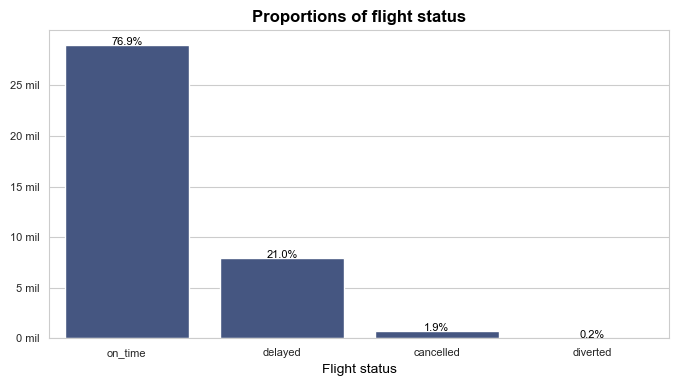

In [24]:
# calculate number of flights per flight status and plot it
flight_status_summary = flights['flight_status'].value_counts(normalize=True)
flight_status = flights['flight_status'].value_counts()
sns.barplot(x=flight_status.index, y=flight_status, color=BASE_COLOR)
plt.ylabel('')
plt.xlabel('Flight status')
plt.title('Proportions of flight status')

locs, labels = plt.xticks()

# for each bar, print a % text at the top of each bar
for loc, label in zip(locs,labels):
    count = flight_status[label.get_text()]
    perc = flight_status_summary[label.get_text()]
    pct_string = '{:0.1f}%'.format(perc*100)
    plt.text(loc, count+0.01, pct_string, ha='center', color='black', size=8, weight='ultralight')
    
ticks = np.arange(0, flight_status[0], 5000000)
labels = ['{:1.0f} mil'.format(tick/1000000) for tick in ticks]
plt.yticks(ticks,labels)

plt.show()

>Around 77% of flights are on time, where as 21% are delayed. Only 2% of flights are cancelled or diverted which is not therefore not the main concern for this analysis

<a id='univariate_numerical'></a>
### Numerical exploration

<span style="color:blue; font-size:16px; font-family: Calibri;">Start by looking at the distribution of the main variables of interest to predict delays: `arrDelay` and `depDelay`</span>

In [25]:
# Take a closer look at distribution of all flights
flights[['depDelay', 'arrDelay']].describe([0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.999]).round(0)

depDelay    arrDelay
count  36991148.0  36913964.0
mean          NaN         NaN
std           NaN         NaN
min           0.0         0.0
25%           0.0         0.0
50%           0.0         0.0
75%           7.0        11.0
85%          20.0        24.0
90%          33.0        38.0
95%          62.0        67.0
99%         146.0       154.0
99.9%       302.0       309.0
max        2600.0      2598.0

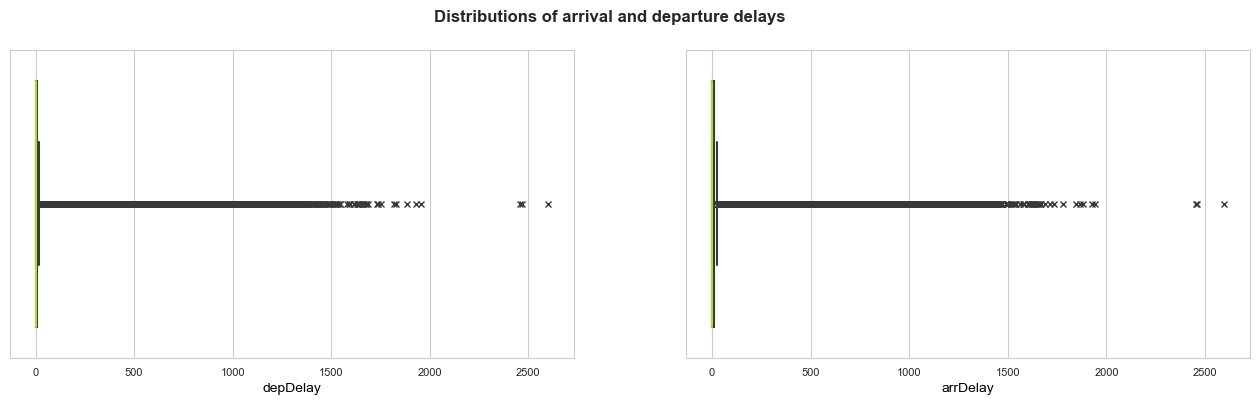

In [26]:
# plot distribution of arrival and departure delays using boxplots
fig, ax = plt.subplots(ncols=2, figsize=(16,4))   

plt.subplot(1,2,1)
sns.boxplot(data=flights, x='depDelay', color = BASE_COLOR_DEP, flierprops={"marker": "x"}, medianprops={"color": BASE_HIGHLIGHT })

plt.subplot(1,2,2)
sns.boxplot(data=flights, x='arrDelay', color = BASE_COLOR_ARR, flierprops={"marker": "x"}, medianprops={"color": BASE_HIGHLIGHT })

plt.suptitle('Distributions of arrival and departure delays')
plt.show()

> At 99.999% percentile, we have delays of around 310 minutes, where the max is quite extreme at around 2600 minutes. It's also visible in the box plot that we have severe outliers

> Remove all outliers where departure delay > 310 minutes

In [27]:
# drop outliers
# get rows to drop where delays are >= 310 minutes
rows_to_drop = flights.loc[(flights['depDelay'] >= 310) | (flights['arrDelay'] >= 310)]
flights.drop(index=rows_to_drop.index, inplace=True)

In [28]:
# extract delayed flights into a seperate dataset
flight_delays = flights.loc[flights['flight_status'] == 'delayed'].copy()

In [29]:
# get all columns of type float
float_columns = list(flight_delays.select_dtypes(include=['float16']).columns)

# convert all float columns to int16, which should now be possible as cancelled and diverted data had a lot of missing values in
flight_delays[float_columns] = flight_delays[float_columns].astype('int16')

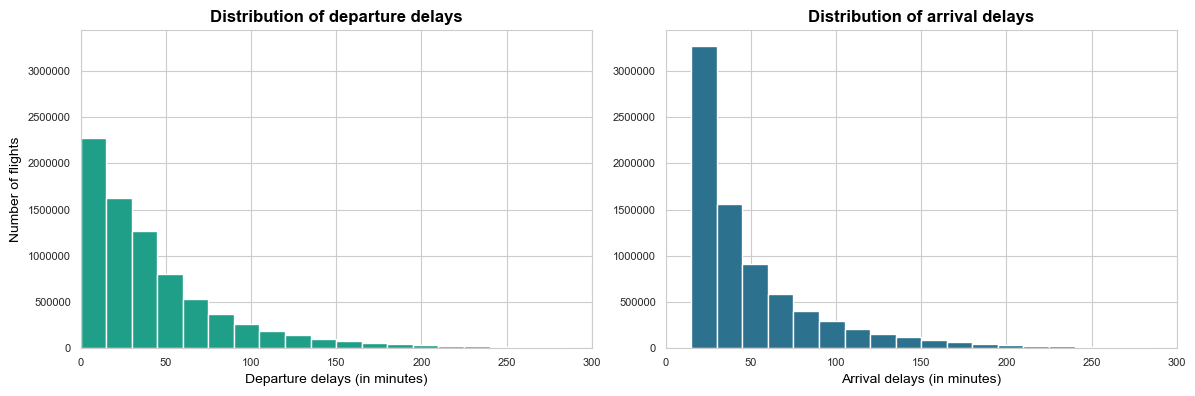

In [30]:
plt.figure(figsize=[12,4])

xbins = np.arange(0, flight_delays['arrDelay'].max()+15, 15)

# plot 1 - distribution of departure delays
ax1 = plt.subplot(1, 2, 1)
ax1.hist(data=flight_delays, x='depDelay', bins=xbins, color=BASE_COLOR_DEP)

plt.xlabel('Departure delays (in minutes)')
plt.ylabel('Number of flights')
plt.xlim(0, 300)
plt.title('Distribution of departure delays')

# plot 2 - distribution of arrival delays
ax2 = plt.subplot(1, 2, 2, sharey=ax1, sharex=ax1)
ax2.hist(data=flight_delays, x='arrDelay', bins=xbins, color=BASE_COLOR_ARR)
plt.xlabel('Arrival delays (in minutes)')
plt.title('Distribution of arrival delays')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

> Distribution of delays are right skewed, with arrivals showing a higher peak between 15-30 minutes as we dropped records with delay < 15 minutes

<span style="color:blue; font-size:16px; font-family: Calibri;">As the distribution of delays are right skewed, lets plot delays using a log distribution instead</span>

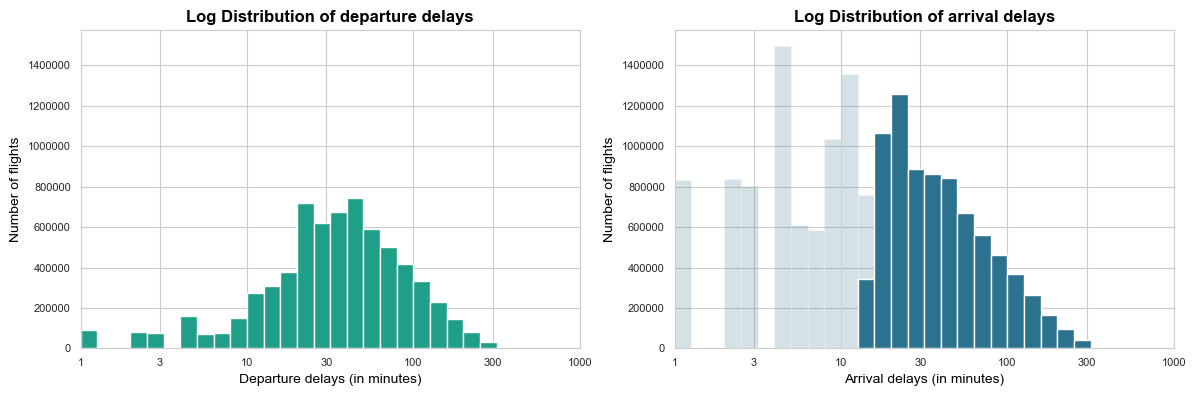

In [31]:
# plot log distribution of delays

plt.figure(figsize=[12,4])

log_binsize = 0.1
bins= 10 ** np.arange(0, np.log10(flight_delays['arrDelay'].max())+log_binsize, log_binsize)
ticks = [1, 3, 10, 30, 100, 300, 1000]
labels = ['{}'.format(tick) for tick in ticks]

ax2 = plt.subplot(1, 2, 2)
plt.hist(data=flights.loc[flights['flight_status'] == 'on_time'], x='arrDelay', bins=bins, color=BASE_COLOR_ARR, alpha=0.2)
plt.hist(data=flights.loc[flights['flight_status'] == 'delayed'], x='arrDelay', bins=bins, color=BASE_COLOR_ARR)
plt.xscale('log')
plt.xticks(ticks, labels)
plt.xlabel('Arrival delays (in minutes)')
plt.ylabel('Number of flights')
plt.title('Log Distribution of arrival delays')
plt.ticklabel_format(style='plain', axis='y')
plt.xlim(1, 300)

ax1 = plt.subplot(1, 2, 1, sharex=ax2, sharey=ax2)
plt.hist(data=flights.loc[flights['flight_status'] == 'delayed'], x='depDelay', bins=bins, color=BASE_COLOR_DEP)
plt.xticks(ticks, labels)
plt.xlabel('Departure delays (in minutes)')
plt.ylabel('Number of flights')
plt.title('Log Distribution of departure delays')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()

>When delays are plotted on a log scale, arrival delays are still right skewed whilst departure delays are more normally distributed.
Arrival delays were restricted to >= 15 minutes, which was not the case for departure delays, which could explain the difference. (light blue on arrDelay plot are those flights with < 15 minutes delay, just to have the full picture)

>Departures have a mean average of around 30-40 minute delay, whilst arrivals have a mean average of 20 minutes delay. There is a steep decline in arrival delays > 20 minutes.

<span style="color:blue; font-size:16px; font-family: Calibri;">What are the main reasons for delays ?</span>

In [32]:
# drop records where all delay reasons are 0, means reasons are not available
delay_reasons = flight_delays.loc[flight_delays[['carrierDelay','weatherDelay','NASDelay','securityDelay','lateAircraftDelay']].sum(axis=1) != 0]

In [33]:
# calculate the mean minutes and proportion of each reason
delay_reason_melt = pd.melt(delay_reasons, value_vars = ['carrierDelay','weatherDelay','NASDelay','securityDelay','lateAircraftDelay'], value_name='minutes')
delay_reason_melt = delay_reason_melt.groupby('variable')['minutes'].agg(['sum', 'mean'])
delay_reason_melt['perc'] = delay_reason_melt['sum']/delay_reason_melt['sum'].sum()*100
delay_reason_melt.sort_values(by='perc', ascending=False, inplace=True)
delay_reason_melt.head()

sum       mean       perc
variable                                          
lateAircraftDelay  138871488  18.551466  36.092073
NASDelay           120850739  16.144123  31.408561
carrierDelay       102318718  13.668480  26.592173
weatherDelay        21893841   2.924739   5.690110
securityDelay         835270   0.111581   0.217083

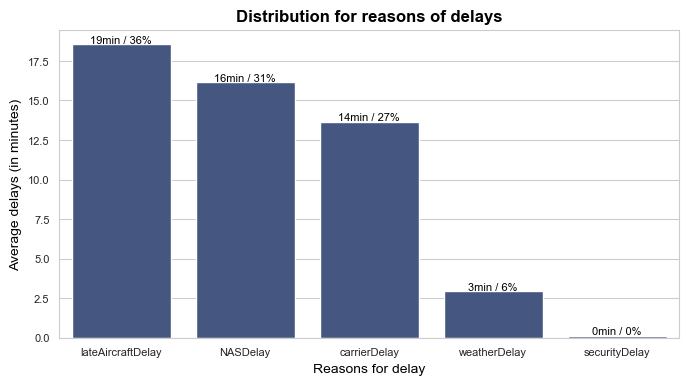

In [34]:
sns.barplot(data=delay_reason_melt, x=delay_reason_melt.index, y='mean', color=BASE_COLOR)

plt.title('Distribution for reasons of delays')
plt.xlabel('Reasons for delay')
plt.ylabel('Average delays (in minutes)')

# for each bar, print % of total delay at the top of each bar
locs, labels = plt.xticks()
for loc, label in zip(locs,labels):
    bar = delay_reason_melt.loc[label.get_text()]
    pct_string = '{:0.0f}min / {:0.0f}%'.format(bar['mean'], bar['perc'])
    plt.text(loc, bar['mean']+0.1, pct_string, ha='center', color='black', size=8, weight='ultralight')

plt.show()

>The top 3 reasons for delays are caused by late aircrafts, NAS, and carriers
>- 36% of delays are caused by late aircrafts with an average of 19 minutes delay
>- 32% of delays are caused by NAS with an average of 16 minutes delay
>- 26% of delays are caused by carriers with an average of 13 minutes delay
>- Weather and security cause only 6% of all delays

<span style="color:blue; font-size:16px; font-family: Calibri;">How are top 3 reasons for delay distributed ?</span>

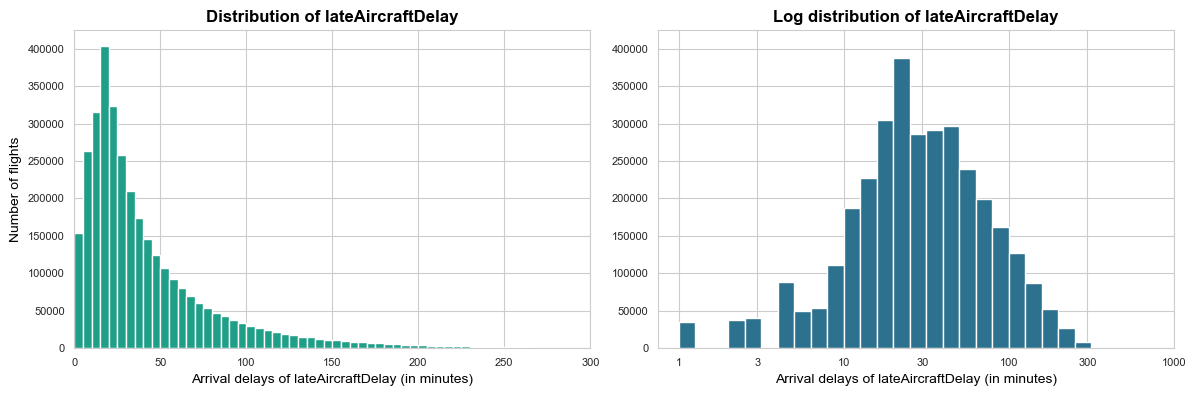

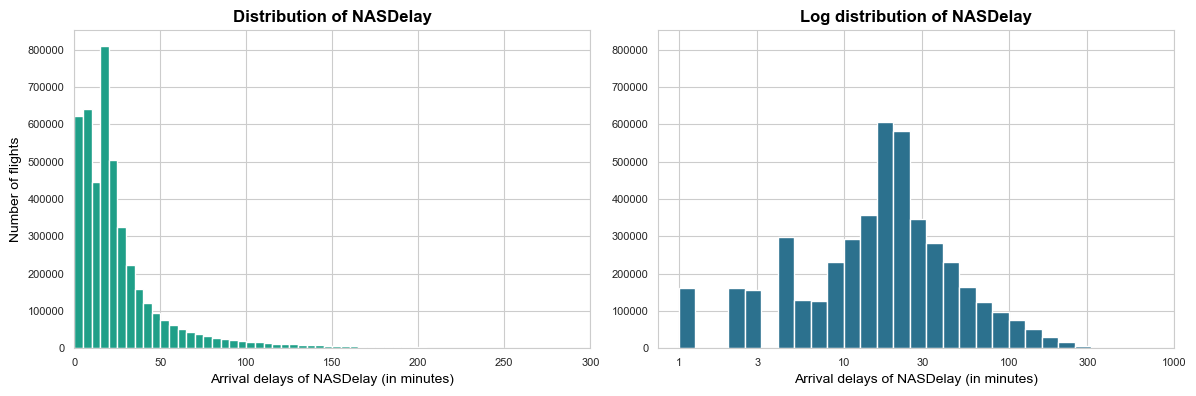

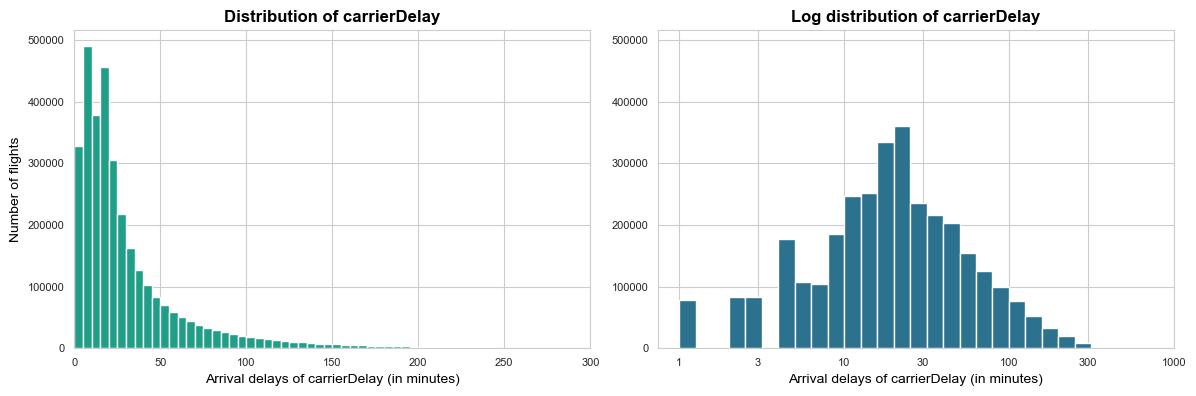

In [35]:
for col in ['lateAircraftDelay', 'NASDelay', 'carrierDelay']:
     
    plt.figure(figsize=[12,4])  
    
    # plot 2 - log distribution for reason of delay
    ax2 = plt.subplot(1, 2, 2)    
       
    log_binsize = 0.1
    bins= 10 ** np.arange(0, np.log10(delay_reasons[col].max())+log_binsize, log_binsize)
    ticks = [1, 3, 10, 30, 100, 300, 1000]
    labels = ['{}'.format(tick) for tick in ticks]

    plt.hist(data=delay_reasons, x=col, bins=bins, color=BASE_COLOR_ARR)
    plt.xscale('log')
    plt.xticks(ticks,labels)
    plt.xlabel('Arrival delays of {} (in minutes)'.format(col))
    plt.title('Log distribution of {}'.format(col))    
    
    # plot 1 - distribution of reason for delay
    xbins = np.arange(0, delay_reasons[col].max()+5, 5)

    ax1 = plt.subplot(1, 2, 1, sharey=ax2)
    plt.hist(data=delay_reasons.loc[delay_reasons[col] > 0], x=col, bins=xbins, color=BASE_COLOR_DEP)
      
    plt.xlabel('Arrival delays of {} (in minutes)'.format(col))
    plt.ylabel('Number of flights')
    plt.xlim(0, 300)
    plt.title('Distribution of {}'.format(col))
    
    plt.tight_layout()

>Late aircrafts, NAS and carrier delays are all right skewed, with a normal distribution on log scale. The mean delay on log scale are around 20-25 min

<a id='univariate_timeseries'></a>
### Time Series Exploration

<span style="color:blue; font-size:16px; font-family: Calibri;">When is the best time of day/day of week/time of year to fly to minimise delays?</span>

Build a time series to view flight and delay patterns at different period intervals to discover possible trends and peaks

In [36]:
# build a timeseries dataset with datatime field as index
flight_timeseries_day = flights.groupby('dateh')['flight_status'].value_counts().unstack()
flight_timeseries_day['total_flights'] = flight_timeseries_day.sum(axis=1)
flight_timeseries_day['diff_delay'] = flight_timeseries_day['delayed'].diff()
flight_timeseries_day['pct_delay'] = flight_timeseries_day['delayed'].pct_change()
flight_timeseries_day.head()

flight_status        delayed  diverted  on_time  total_flights  diff_delay  \
dateh                                                                        
2003-01-01 00:00:00      6.0       NaN     25.0           31.0         NaN   
2003-01-01 01:00:00      5.0       NaN     14.0           19.0        -1.0   
2003-01-01 02:00:00      NaN       NaN      3.0            3.0         NaN   
2003-01-01 03:00:00      1.0       NaN      NaN            1.0         NaN   
2003-01-01 04:00:00      NaN       NaN      1.0            1.0         NaN   

flight_status        pct_delay  
dateh                           
2003-01-01 00:00:00        NaN  
2003-01-01 01:00:00  -0.166667  
2003-01-01 02:00:00   0.000000  
2003-01-01 03:00:00  -0.800000  
2003-01-01 04:00:00   0.000000

In [37]:
flight_timeseries_day.tail()

flight_status        delayed  diverted  on_time  total_flights  diff_delay  \
dateh                                                                        
2008-04-30 19:00:00    200.0       1.0   1004.0         1205.0        27.0   
2008-04-30 20:00:00    167.0       NaN    659.0          826.0       -33.0   
2008-04-30 21:00:00    119.0       NaN    607.0          726.0       -48.0   
2008-04-30 22:00:00     52.0       NaN    212.0          264.0       -67.0   
2008-04-30 23:00:00     17.0       NaN     69.0           86.0       -35.0   

flight_status        pct_delay  
dateh                           
2008-04-30 19:00:00   0.156069  
2008-04-30 20:00:00  -0.165000  
2008-04-30 21:00:00  -0.287425  
2008-04-30 22:00:00  -0.563025  
2008-04-30 23:00:00  -0.673077

>2008 does not contain data for the full year, only Jan - April is available. Drop this year from all data

In [38]:
# drop 2008 from all data as it's not a full year
flight_timeseries_day = flight_timeseries_day.loc[flight_timeseries_day.index.year < 2008]
flights = flights.loc[flights['year'] < 2008]
flight_delays = flight_delays.loc[flight_delays['year'] < 2008]

#### Let's start by looking of the distribution of flights vs delays per year

In [39]:
# create a yearly time series
freq = 'Y'
flight_timeseries_year = flight_timeseries_day.resample(freq).sum()
flight_timeseries_year['pct_delay'] = flight_timeseries_year['delayed'].pct_change()
flight_timeseries_year['pct_all'] = flight_timeseries_year['total_flights'].pct_change()

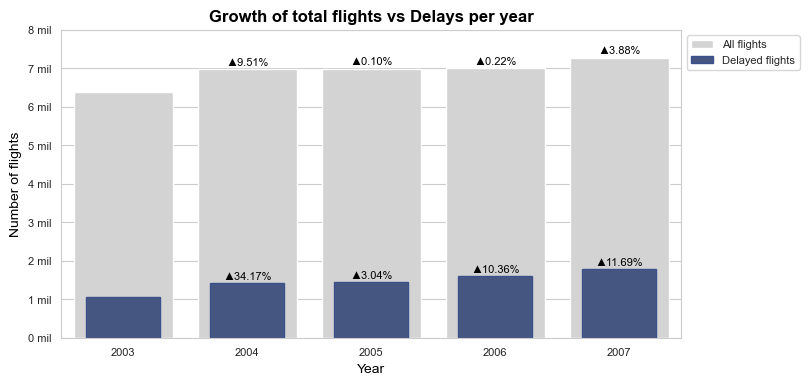

In [40]:
# plot distribution of flights and delays year on year
plt.figure(figsize=[8,4])

sns.barplot(data=flight_timeseries_year, x=flight_timeseries_year.index.year, y='total_flights', color=BASE_GREY, label='All flights')
sns.barplot(data=flight_timeseries_year, x=flight_timeseries_year.index.year, y='delayed', color=BASE_COLOR, label='Delayed flights', width=0.6, edgecolor=BASE_COLOR)

# for each blue bar (delays), print % delays over total flights year on year 
locs, labels = plt.xticks()
for loc, label in zip(locs,labels):
    date = pd.to_datetime(label.get_text()).strftime('%Y')
    date = date + '-12-31'
    counts = flight_timeseries_year.loc[date]
    
    # add positive or negative sign
    symbol = ''
    if pd.isna(counts['pct_delay']):
        continue
    elif counts['pct_delay'] > 0:
        symbol = SYMBOLS[1]
    elif counts['pct_delay'] < 0:
        symbol = SYMBOLS[0]
    
    pct_string_delay = '{}{:0.2f}%'.format(symbol, round(counts['pct_delay']*100,2))
    pct_string_all = '{}{:0.2f}%'.format(symbol, round(counts['pct_all']*100,2))
    plt.text(loc, counts.delayed+100000, pct_string_delay, ha='center', color='black', fontsize=8)
    plt.text(loc, counts.total_flights+100000, pct_string_all, ha='center', color='black', fontsize=8)
    
binsize=1000000
yticks = np.arange(0, flight_timeseries_year['total_flights'].max()+binsize, binsize)
ylabels = ['{:1.0f}'.format(tick/1000000)+' mil' for tick in yticks]
plt.yticks(yticks, ylabels)    

plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
plt.title('Growth of total flights vs Delays per year')
plt.xlabel('Year')
plt.ylabel('Number of flights')

plt.show()

>Both the total number of flights and delays increase every year, we see an upwards trend. The growth rate of delays are higher than flight growth.

#### Can we spot peaks in months ? For example are summer months and xmas causing delays at airports ?

In [41]:
# create a monthly time series
freq = 'M'
flight_timeseries_month = flight_timeseries_day.resample(freq).sum()
flight_timeseries_month['pct_delay'] = flight_timeseries_month['delayed'].pct_change()
flight_timeseries_month['pct_all'] = flight_timeseries_month['total_flights'].pct_change()
flight_timeseries_month['diff_delay'] = flight_timeseries_month['delayed'].diff()
flight_timeseries_month['pct_diff_delay'] = flight_timeseries_month['diff_delay'].pct_change()

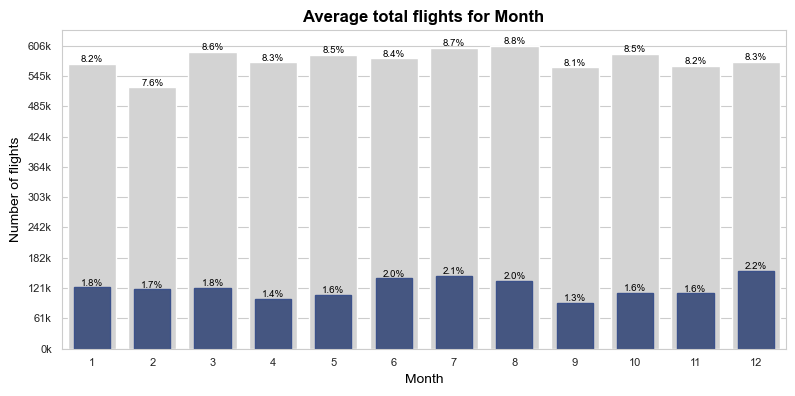

In [42]:
# plot proportion total flights vs delayed flights per month
vs.plot_period_stacked(df=flight_timeseries_month, col=flight_timeseries_month.index.month, annotate=True, title='Month', rotate=False)

>We see peaks in delay June-August and Dec-March, but due to the high of the bars, the variation is not so clear

#### Plot proportion total flights vs delayed flights per month, but this time plot them seperately with different axis, to view the variation in months better.

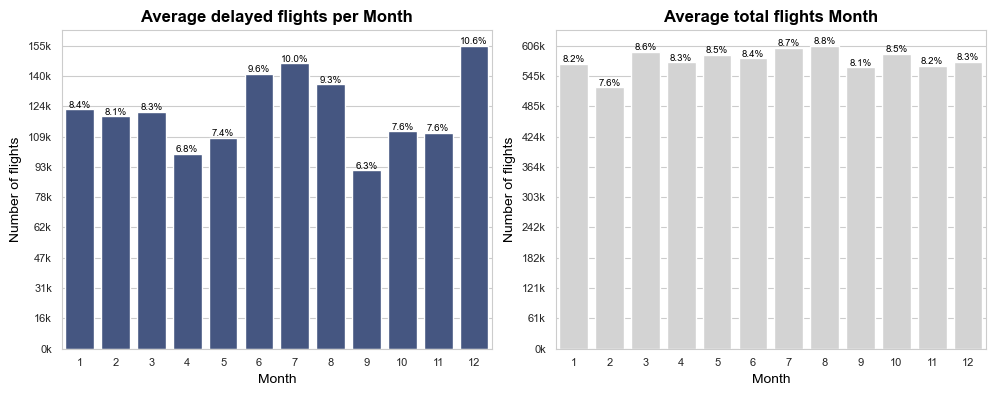

In [43]:
vs.plot_period_side_by_side(df=flight_timeseries_month, col=flight_timeseries_month.index.month, annotate=True, title='Month', rotate=False, sharey=False)

>The biggest peaks in **delays** are in summer months June-August and xmas period December-March. Delays decrease in spring/autumn months.

>There is not as much variation in the average **total** flights per month, the summer and christmas peaks are not so immediately evidant. This indicates that the number of flights does not drastically increase, however delays do increase more proportionally during peak seasons

#### Can we spot peaks in certain days of the month ? 

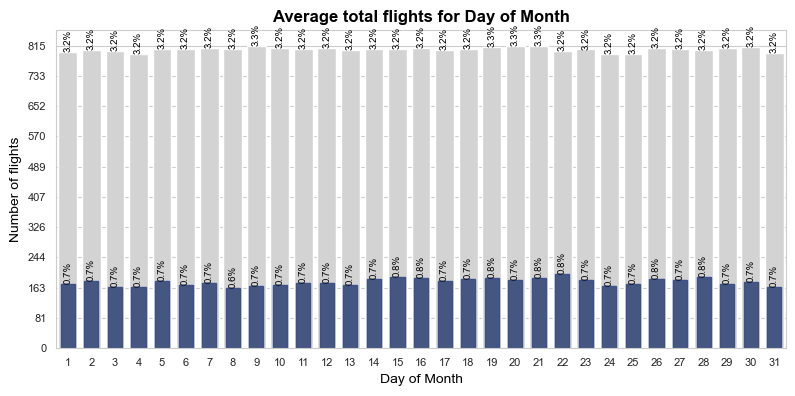

In [44]:
vs.plot_period_stacked(df=flight_timeseries_day, col=flight_timeseries_day.index.day, annotate=True, title='Day of Month', rotate=True)

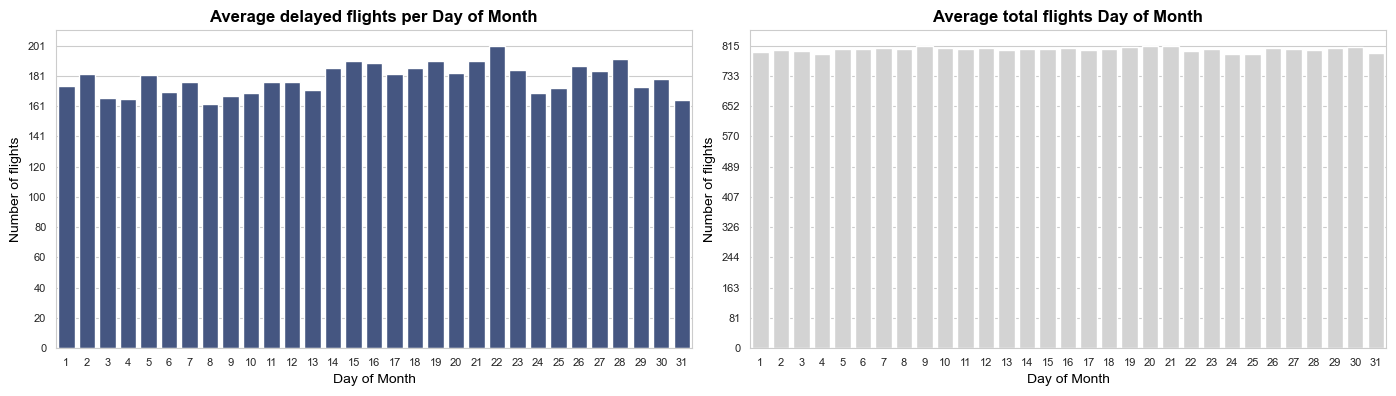

In [45]:
vs.plot_period_side_by_side(df=flight_timeseries_day, col=flight_timeseries_day.index.day, annotate=False, title='Day of Month', rotate=True, sharey=False)

>There are no clear peaks during the month

#### Can we spot peaks in certain days of the week ? 

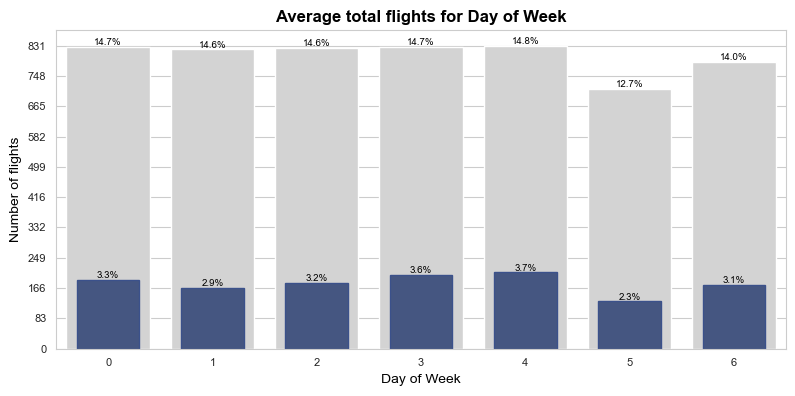

In [46]:
vs.plot_period_stacked(df=flight_timeseries_day, col=flight_timeseries_day.index.dayofweek, annotate=True, title='Day of Week', rotate=False)

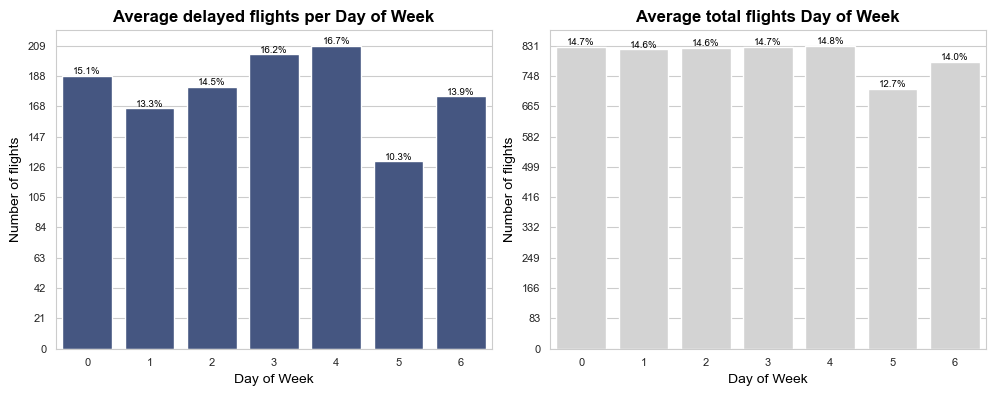

In [47]:
vs.plot_period_side_by_side(df=flight_timeseries_day, col=flight_timeseries_day.index.dayofweek, annotate=True, title='Day of Week', rotate=False, sharey=False)

> Mondays, Thursdays and Fridays are the busiest days, where as Tuesdays and Saturdays are the most quiet. Weekends are more quiet than weekdays

#### Can we spot peaks in certain times of a day ? 

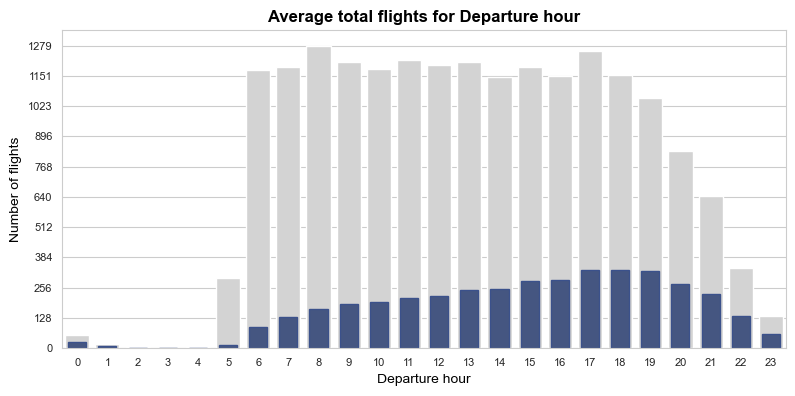

In [48]:
vs.plot_period_stacked(df=flight_timeseries_day, col=flight_timeseries_day.index.hour, annotate=False, title='Departure hour', rotate=False)

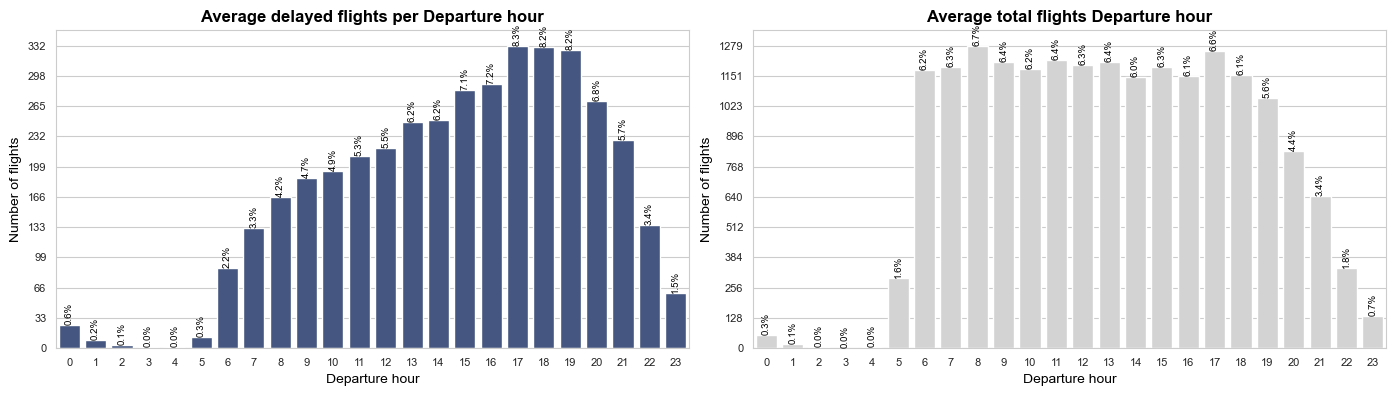

In [49]:
vs.plot_period_side_by_side(df=flight_timeseries_day, col=flight_timeseries_day.index.hour, annotate=True, title='Departure hour', rotate=True, sharey=False)

>Delays are growing progressively throughout the day starting at 6am until 8pm where as the total number of flights stay constant. Delay peaks are between for 5-8pm. 
From 8pm, both the delays and number of flights decrease.  

#### Can we confirm the seasonal patterns for summer and xmas periods in time series plotting?

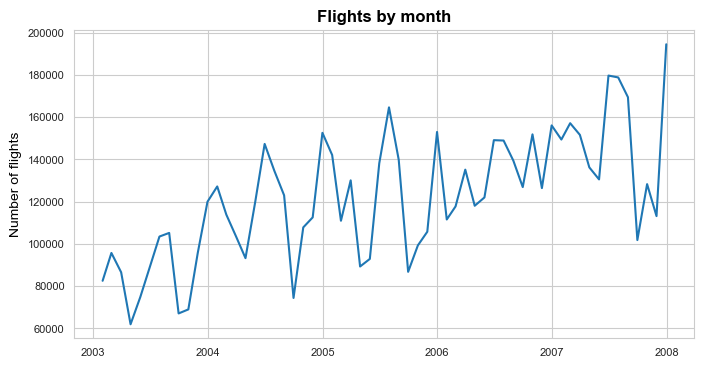

In [50]:
plt.errorbar(x=flight_timeseries_month.index, y=flight_timeseries_month['delayed'])
plt.title('Flights by month')
plt.ylabel('Number of flights')
plt.show()

>We can visually observe an upwards trend in delayed flights per year, delayed flights are increasing. We can observe two peaks and falls in each year

#### Use statsmodels auto and partial correlation to pickup seasonal patterns

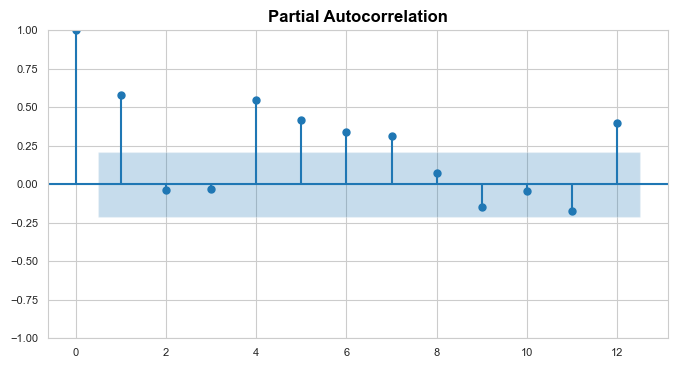

In [51]:
# plotting partial autocorrelations
fig = tsaplots.plot_pacf(flight_timeseries_month['delayed'], lags=12, alpha=0.1, method = "ols")
plt.show()

>Looking at partial auto correlations, a strong correlation at lag 4-7 which suggest a seasonal pattern for the summer peak, and another strong correlation at lag 0, 1, 12 for the xmas period

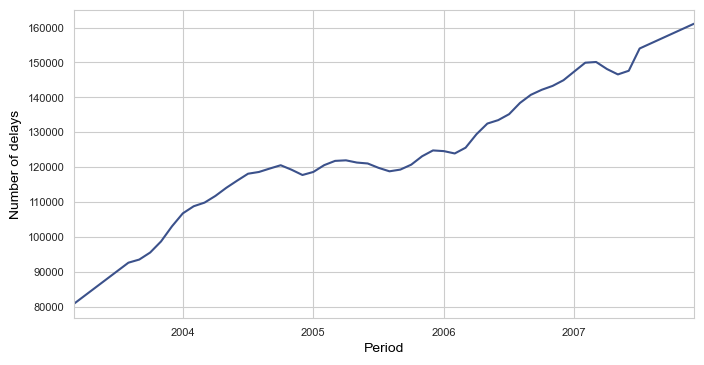

In [52]:
# print seasonal patterns using stats models
plt.rc("figure", figsize=(12,8))
flight_timeseries_month.dropna(inplace=True)
decomposition = sm.tsa.seasonal_decompose(flight_timeseries_month['delayed'], extrapolate_trend='freq')

# Plot the trend
plt.rc("figure", figsize=(8,4))
trend = decomposition.trend
ax = trend.plot(color=BASE_COLOR)
plt.xlabel('Period')
plt.ylabel('Number of delays')
plt.show()

> Again we can confirm an upwards trend in delays year apon year. The seasonal effect was removed from the trend

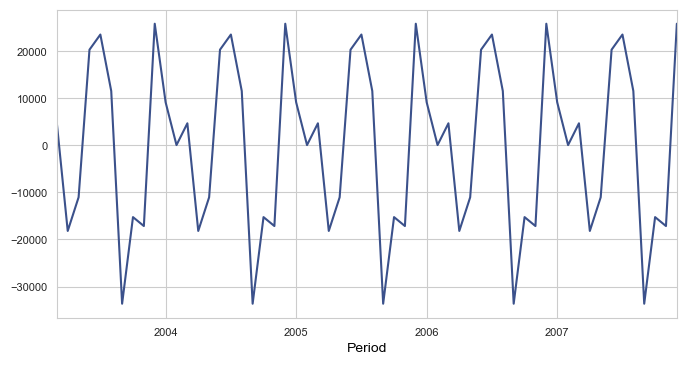

In [53]:
# Display the seasional pattern
season = decomposition.seasonal
ax = season.plot(color=BASE_COLOR)
plt.xlabel('Period')
plt.show()

>Using statmodels we can confirm a strong seasonal pattern during summer and christmas periods. The trend is removed from the series and the average of this de-trended series for each period is the returned seasonal component

### **Numerical & Time Series Summary:**

>When flights increase, delays increase as well, although delays grow at a higher rate.
There is definite upwards trend in flights and delays year apon year.
There is a strong seasonal pattern. There are 2 strong peaks, the biggest one around xmas time in December - March, and another one during summer months June - August.
Mondays, Thursdays and Fridays are the busiest times at airports, it is the most quiet on Tuesdays and Saturdays.
Delays grows progressively throughout the day, with most delays happening between 17:00-20:00

<a id='univariate_categorical'></a>
### Categorical analysis

<span style="color:blue; font-size:16px; font-family: Calibri;">Which **airports** cause the most delays ?</span>

Compare the flight delay and on-time distribution in departure and arrival airports

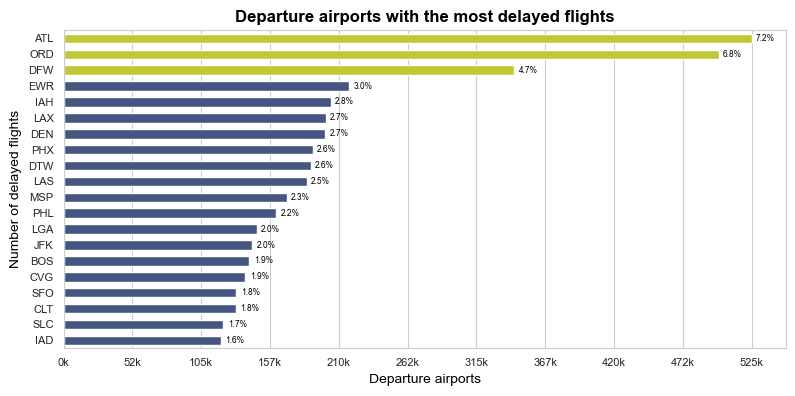

In [54]:
# plot flight delay distribution for departure airports
vs.delays_by_cat(df=flight_delays, col='origin', title='Departure airports')

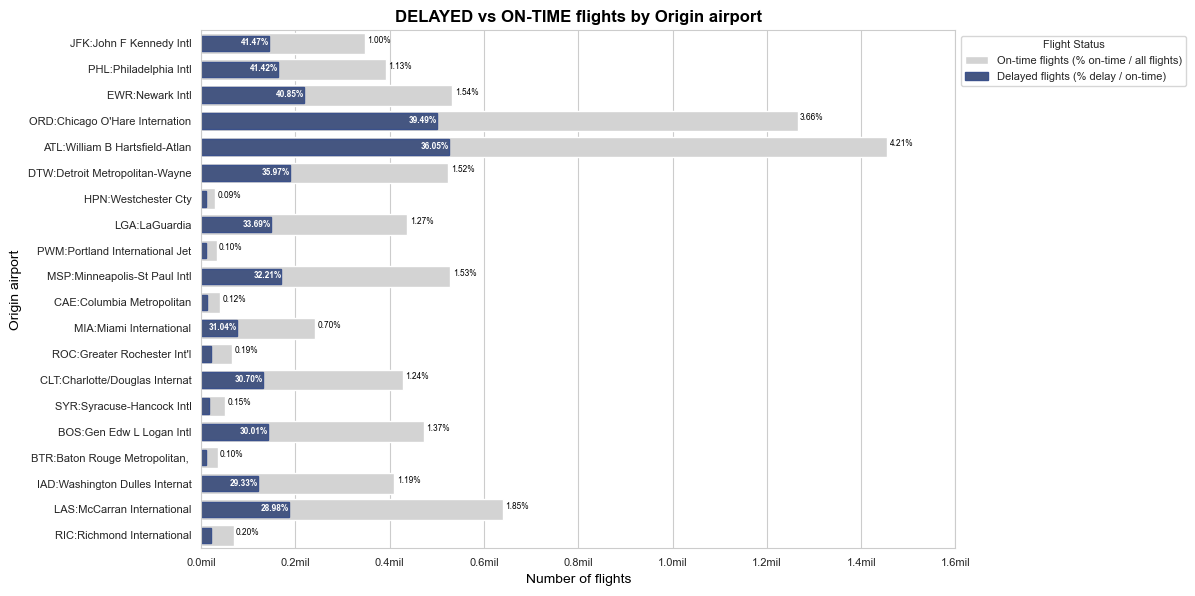

In [55]:
# plot distribution of delayed vs on-time flights for origin/departure airports
origin = flights.groupby('origin')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)
origin['airport'] = origin.index + ':' + airports.loc[origin.index]['airport']
origin.reset_index(inplace=True)
origin.set_index('airport', inplace=True)
origin['prop_delayed'] = origin['delayed'] / (origin['delayed'] + origin['on_time'])
origin_prop = origin.sort_values(by='prop_delayed', ascending=False)
vs.plot_categories(df=origin_prop, title='Origin airport')

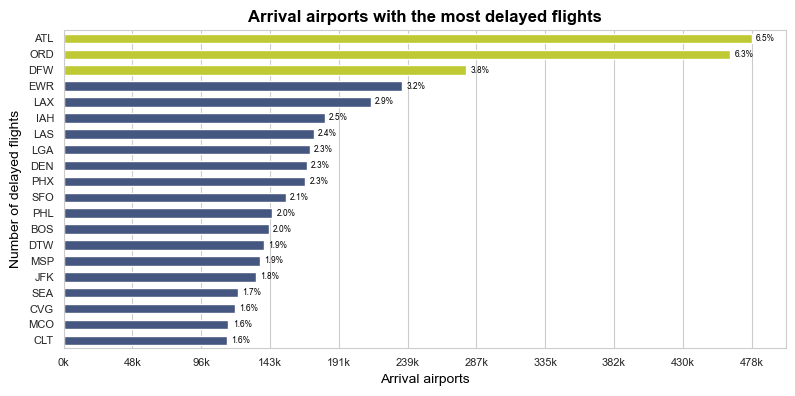

In [56]:
# plot flight delay distribution for arrival airports
vs.delays_by_cat(df=flight_delays, col='dest', title='Arrival airports')

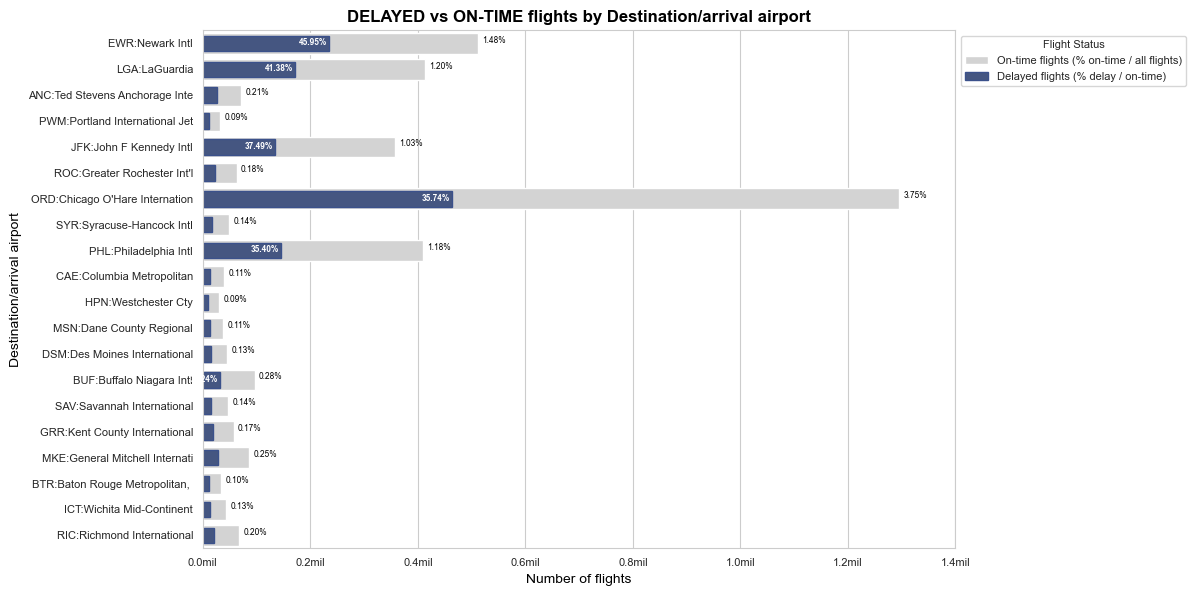

In [57]:
# plot distribution of delayed vs on-time flights for destination airports
dest = flights.groupby('dest')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)
dest['airport'] = dest.index + ':' + airports.loc[dest.index]['airport']
dest.reset_index(inplace=True)
dest.set_index('airport', inplace=True)
dest['prop_delayed'] = dest['delayed'] / (dest['delayed'] + dest['on_time'])
dest.sort_values(by='prop_delayed', ascending=False, inplace=True)
vs.plot_categories(df=dest, title='Destination/arrival airport')

>The top busiest origin/departure airports (ATL, ORD, DFW and EWR) are also the top destination/arrival airports causing delays, meaning a delay in the origin is causing a delay in the destination.
>From a proportional perspective, JFK, PHL, EWR, ORD have over 40% of their flights delayed on departure, whilst EWR, LGA, ANC, JFK, ROC have the biggest delays at destination/arrival airports

<span style="color:blue; font-size:16px; font-family: Calibri;">Which **lanes** cause the most delays ?</span>

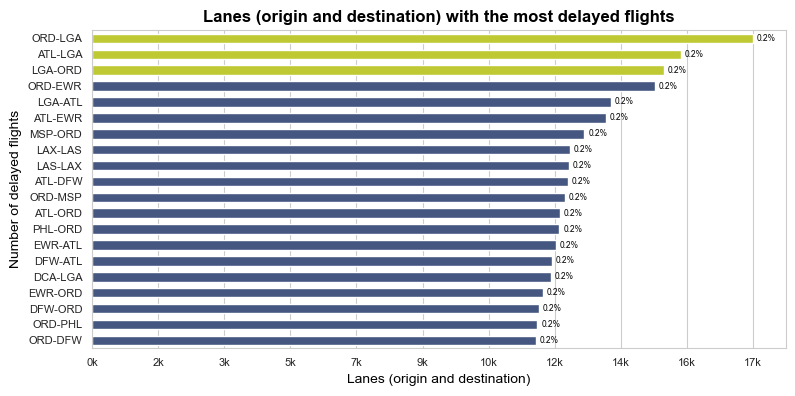

In [58]:
# plot flight delay distribution by lane
vs.delays_by_cat(df=flight_delays, col='lane', title='Lanes (origin and destination)')

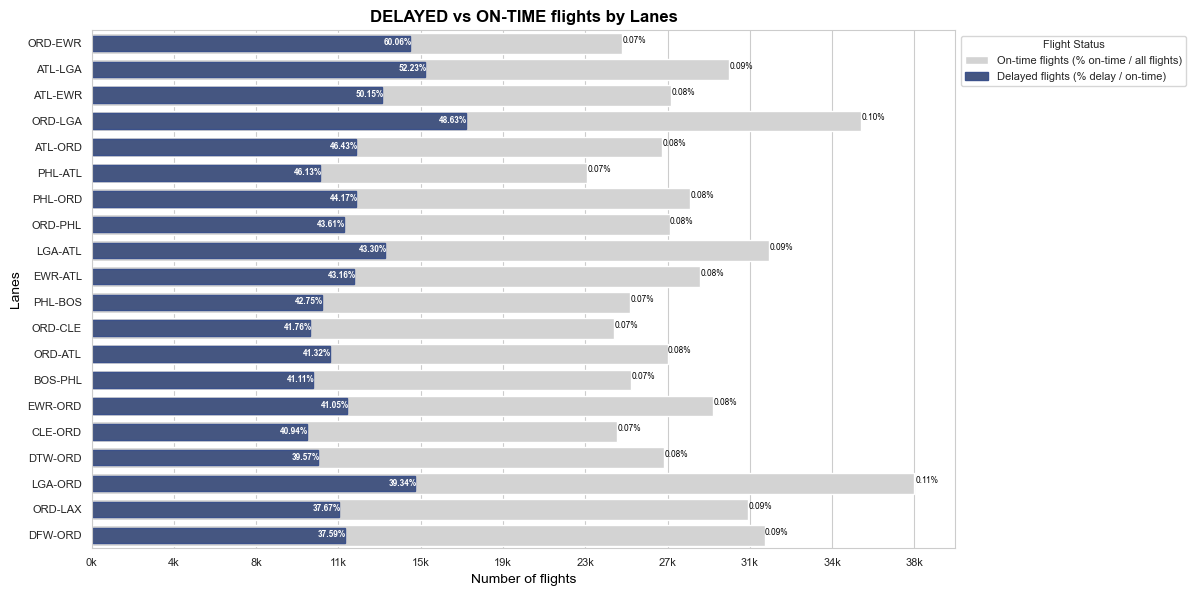

In [59]:
# plot distribution of delayed vs on-time flights by lane (departure + arrival airport)
lanes = flights.groupby('lane')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)
lanes['prop_delayed'] = lanes['delayed'] / (lanes['delayed'] + lanes['on_time'])
lanes_prop = lanes.sort_values(by='prop_delayed', ascending=False)
vs.plot_categories(df=lanes_prop, title='Lanes')

>When looking at lane level, the top lanes with delays have always one of the top 3 delay airports as either origin and/or destination.
>From a proportional perspective, ORD-EWR are a concern with 60% of it's flights delayed. Also ATL-LGA, ORD-LGA, ATL-EWR deserves a shoutout with 48-52% of the flights delayed.

>When a lane consist of a combination where both origin and destination airports are ORD, EWR, ATL, DFW its a definete stay away or take a nice book to read!

<span style="color:blue; font-size:16px; font-family: Calibri;">Which **carriers** cause the most delays ?</span>

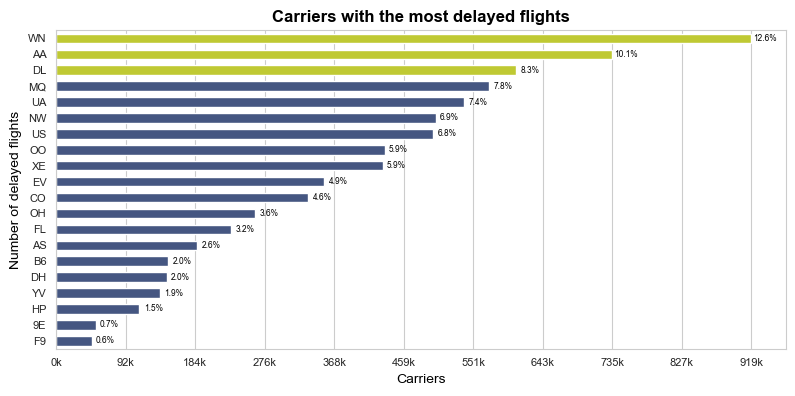

In [60]:
# plot flight delay distribution by carrier
vs.delays_by_cat(df=flight_delays, col='uniqueCarrier', title='Carriers')

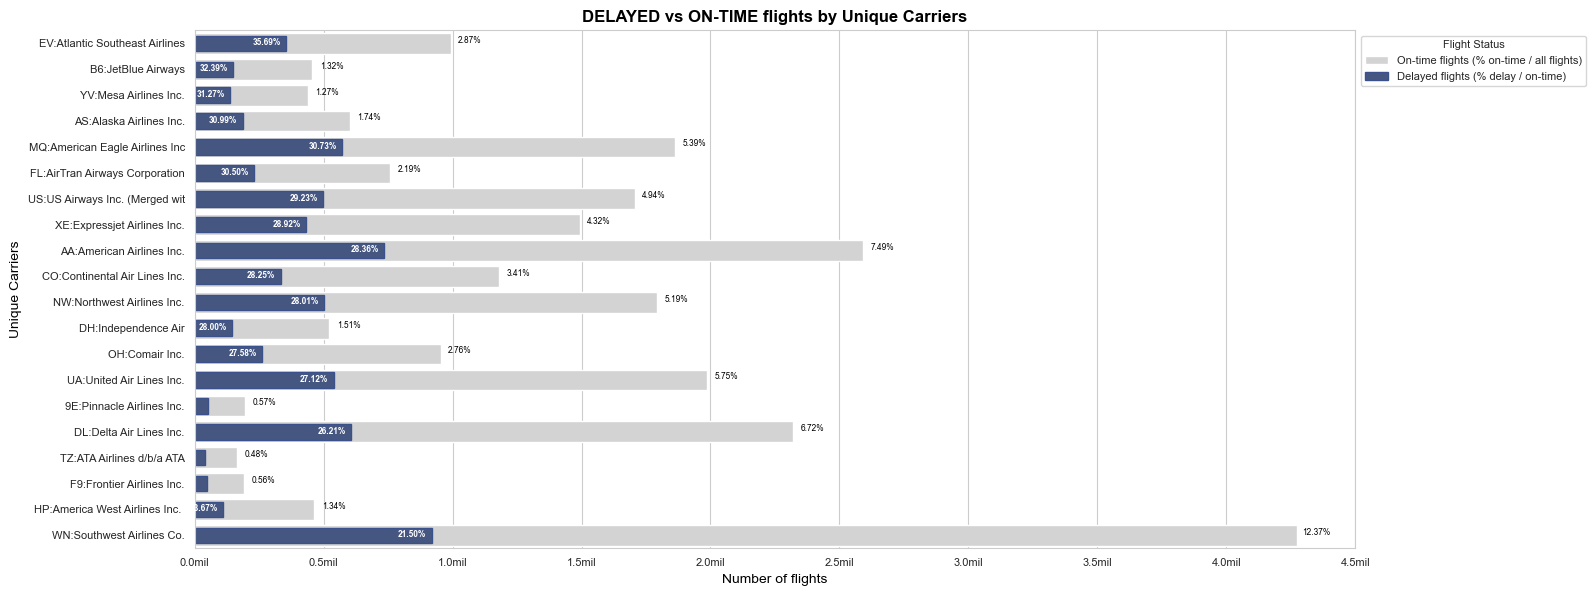

In [61]:
# plot distribution of delayed vs on-time flights by carrier
cat_carrier = flights.groupby('uniqueCarrier')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)
cat_carrier['total_flights'] = cat_carrier.sum(axis=1).astype('int32')
cat_carrier = cat_carrier.merge(carriers, how='inner', on='uniqueCarrier')
cat_carrier = cat_carrier.reset_index()
cat_carrier['carrier'] = cat_carrier.uniqueCarrier + ':' + cat_carrier['carrier_description']
cat_carrier.set_index('carrier', inplace=True)
cat_carrier['prop_delayed'] = cat_carrier['delayed'] / (cat_carrier['delayed'] + cat_carrier['on_time'])
cat_carrier_prop = cat_carrier.sort_values(by='prop_delayed', ascending=False)
vs.plot_categories(df=cat_carrier_prop, title='Unique Carriers', topn=20, figsize=(16,6))

>- Carriers with most delays are WN (Southwest Airlines), AA (Americal Airlines), DL (Delta Air Lines)
>- From proportional perspective, watchouts are EV: Atlantic Southeast at 36% of their flights delayed, B6: Jet Blue at 32%, YV: Mesa Airlines at 31% and MQ: Americaln Eagle at 31%  

<span style="color:blue; font-size:16px; font-family: Calibri;">Which **plane characteristics** causes the most delays ?</span>

Plot plane chacteristics causing delays vs those planes that are on-time

In [62]:
# aggration rule for all category plots
f = {'delayed':'sum', 'on_time':'sum'}

In [63]:
# get plane characteristics
plane_data = flights.groupby('tailNum')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)

plane_data = plane_data.merge(planes, how='inner', right_on='tailnum', left_on='tailNum')

plane_data['year'] = plane_data['year'].replace('None', None)
plane_data['year_issue'] = plane_data['issue_date'].replace('None', None)

plane_data['date1'] = pd.to_datetime(plane_data['year_issue'], errors='coerce', format='%Y/%m/%d')
plane_data['date2'] = pd.to_datetime(plane_data['year_issue'], errors='coerce', format='%m/%d/%Y')
plane_data['year_issue'] = plane_data['date1'].fillna(plane_data['date2'])
plane_data.dropna(axis=0, inplace=True, subset=['year_issue', 'year'])

plane_data['year_issue'] = plane_data['year_issue'].dt.year
plane_data['year_issue'] = plane_data['year_issue'].astype(int)
plane_data['year'] = plane_data['year'].astype(int)

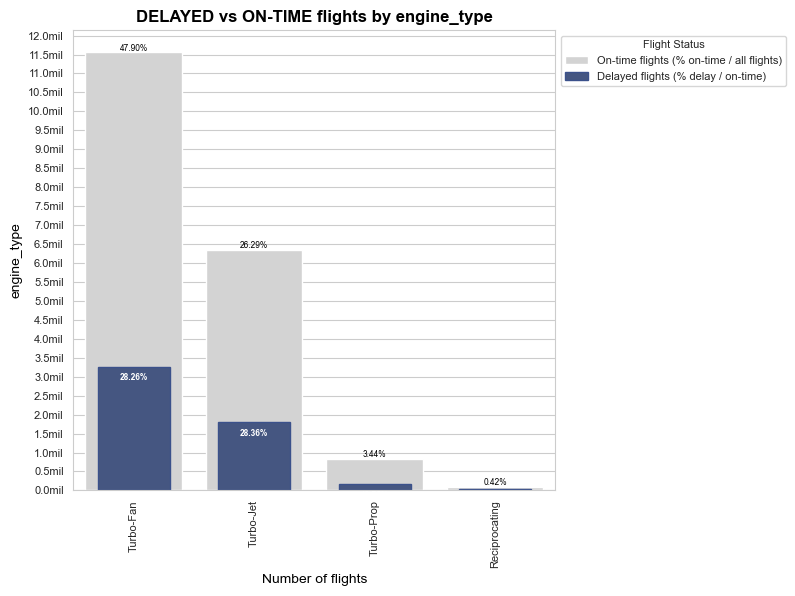

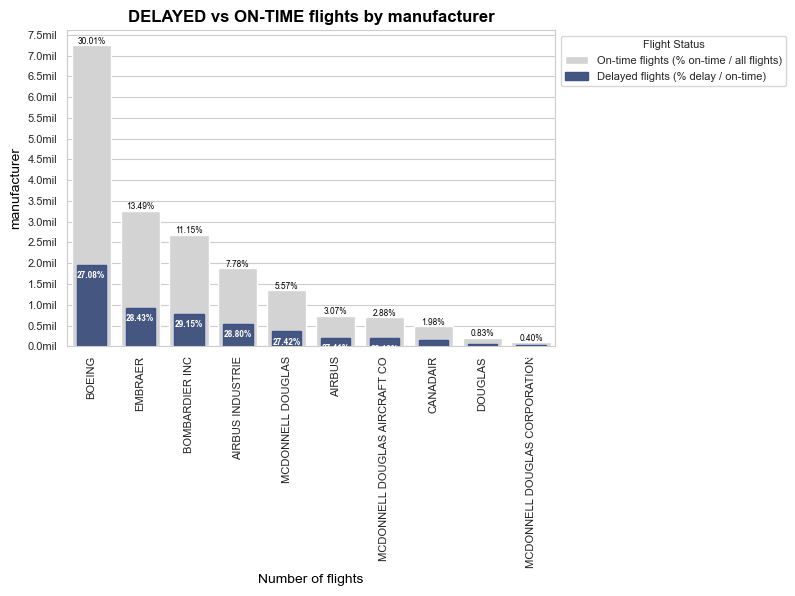

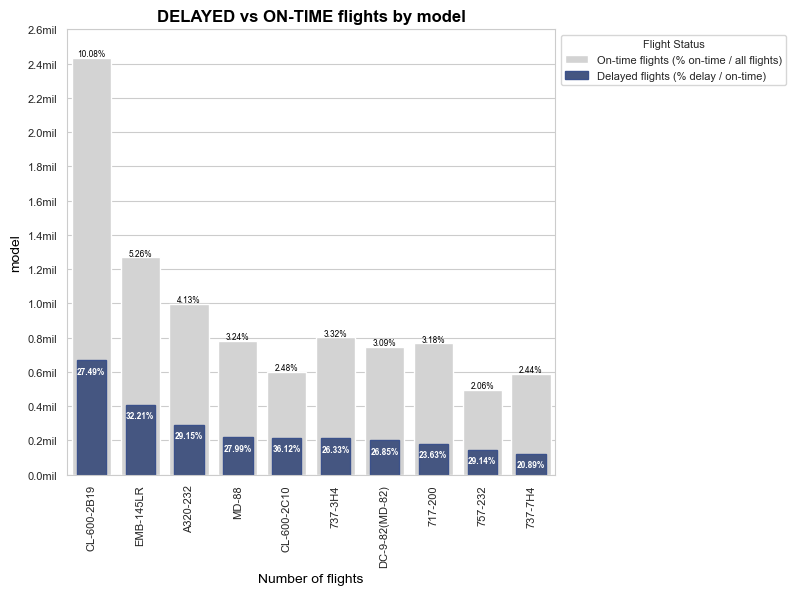

In [64]:
col = ['manufacturer', 'engine_type', 'model']
col.sort()

for c in col:
    df = plane_data.groupby(c).agg(f).sort_values(by='delayed', ascending=False)
    df.index = df.index.astype(str)
    vs.plot_categories(df=df, title=c, topn=10, orient='h',figsize=(8,6))    

>When comparing categorical features using proportion of delays over on-time flights, characteristics are quite similar with a factor of around 30%. 

<span style="color:blue; font-size:16px; font-family: Calibri;">Is it the oldest planes that cause delays ?</span>

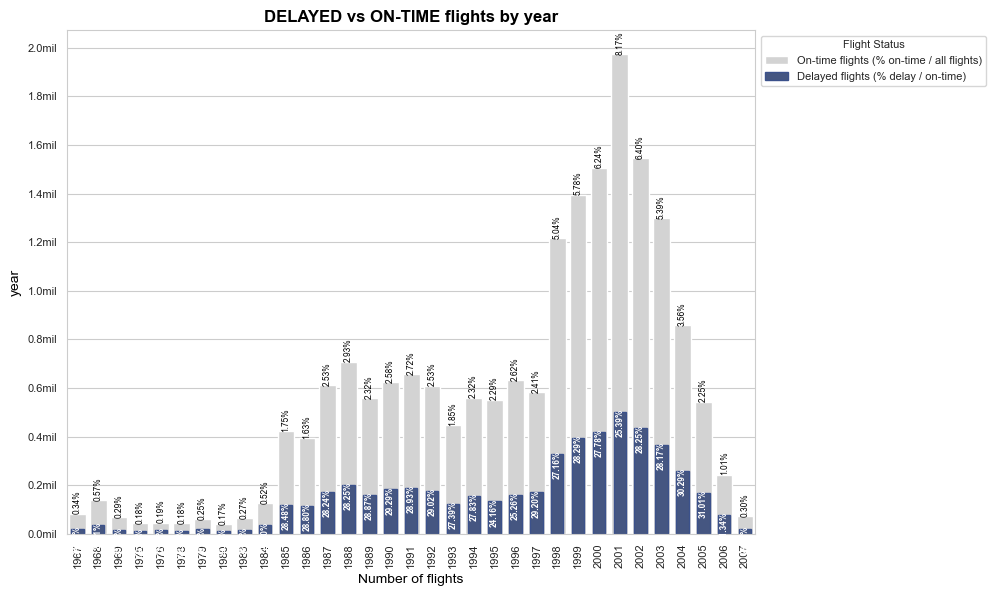

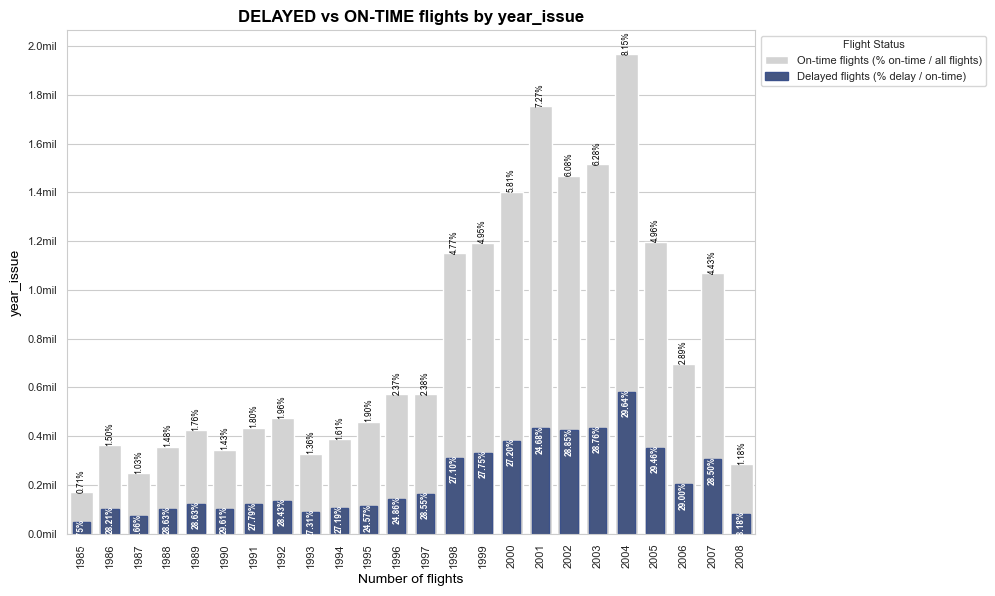

In [65]:
col = ['year', 'year_issue']
col.sort()

for c in col:
    df = plane_data.groupby(c).agg(f)
    df.index = df.index.astype(str)
    vs.plot_categories(df=df, title=c, topn=100, orient='h', rotate=True, figsize=(10,6))    

>Ironically, delays occur in more younger planes. Planes from year 2004 seem to cause the most delays which is quite surprising.

In [66]:
# save the enhanced flight file where outliers was removed, as pickle file to reuse during explanatory analysis
flights.to_pickle(FILE_NAME_ENHANCED)

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

<blockquote>


**Most signifant findings:**

- Around 76% of all flights are on-time, where as **21% of all flights are delayed**. Only 2% of flights are cancelled or diverted which is therefore not the main concern of our analysis.

- Both **`depDelay` (departure delay) and `arrDelay` (arrival delay) ** in minutes are **right skewed**. When plotted on a log scale, arrival delays are still right skewed whilst departure delays are more normally distributed. Arrival delays were restricted to >= 15 minutes, which was not the case for departure delays, otherwise departure delays would also be right skewed.
    
- At 99.999% percentile for both `depDelay` and `arrDelay`, we have delays of around 310 minutes, where the max is quite extreme at around 2600 minutes. It's also visible in the box plot that we have severe outliers. All outliers where delays > 310 minutes were removed as these are quite unusual.

- For flights classified as late, departures have a mean average of a 30 minute delay, whilst arrivals have a mean average of a 20 minutes delay. Departure mean delay > arrival mean delay, could there be catch-up of time during the flight? There is a steep decline in arrival delays > 20 minutes.

- The **top 3 reasons for delays** are caused by **late aircrafts, NAS (Air traffic control), and carriers**:
    - 36% of delays are caused by late aircrafts with an average of 19 minutes delay
    - 32% of delays are caused by NAS with an average of 16 minutes delay 
    - 26% of delays are caused by carriers with an average of 13 minutes delay
    - Weather and security cause only 6% of all delays
 
- Late aircraft, NAS and carrier delays are all right skewed, with a normal distribution on log scale. The mean delay on log scale are around 20-25 min

- When flights increase, delays increase as well, although delays grow at a higher rate proportionally. There is definite **upwards trend in flights and delays year apon year**. Demand is increasing, but so does the delays.

- There is a **strong seasonal pattern**. There are 2 strong peaks, the biggest one around Christmas time in **December - March**, and another one during summer months **June - August**. Delays decrease in spring/autumn months.

- **Most delays happens on weekdays on Mondays, Thursdays and Fridays**. Tuesdays and Saturdays are the quietest days. Airports are less busy with less delays on weekends.
    
- Delays are growing progressively throughout the day starting at 6am until 8pm where as the total number of flights stay constant. **Delay peaks are between for 5-8pm**. 
From 8pm, both the delays and number of flights decrease.  

- Percentage difference per month for delays have a much larger range than percentage difference for all flights. This indicates that throughout the year, roughly the same number of flights fly between locations, whereas **we experience more delays in airports during peak times**. 
  
- The top **origin/departure airports** **ATL, ORD, DFW and EWR** are also the top destination/arrival airports causing delays, suggesting a delay in the origin is causing a delay in the destination.
    
- From a proportional perspective, JFK, PHL, EWR, ORD have over 40% of their flights delayed on departure, whilst EWR, LGA, ANC, JFK, ROC have the biggest delays at destination/arrival airports
    
- When looking at **lane level**, the top lanes with delays have always one of the top 3 delay airports as either origin and/or destination. From a proportional perspective, **ORD-EWR** are a concern with **60% of it's flights delayed** Also **ATL-LGA, ORD-LGA, ATL-EWR** deserves a shout-out with **48-52% of the flights delayed**. When a lane consist of a combination where both origin and destination airports are ORD, EWR, ATL, DFW its a definete stay away or take a nice book to read!
  
- **Carriers** with the most overall delays are **WN (Southwest Airlines), AA (Americal Airlines), DL (Delta Air Lines)**
- From proportional perspective, watchouts are **EV: Atlantic Southeast at 36% of their flights delayed**, **B6: Jet Blue at 32%, YV: Mesa Airlines at 31% and MQ: Americaln Eagle at 31%** 

- Ironically, most delays occur in younger planes, especially from the year 2004.

- When comparing **categorical plane features** using proportion of delays over on-time flights, characteristics are quite similar with a factor of around 30%. **Delays seem to be evenly distributed and are not caused by certain planes**.

**Summary:**
    
When flights increase, delays increase as well, although delays grow at a higher rate.
There is definite upwards trend in flights and delays year apon year.
There is a strong seasonal pattern. There are 2 strong peaks, the biggest one around xmas time in December - March, and another one during summer months June - August.
Mondays, Thursdays and Fridays are the busiest times at airports, it is the most quiet on Tuesdays and Saturdays.
Delays grows progressively throughout the day, with most delays happening between 5pm-8pm.
Airports on watch: ATL, ORD, DFW, EWR, JFK, PHL 
Çarriers on watch: EV, B6, YV, WN, AA, DL
Lanes on watch: ORD-EWR, ATL-LGA, ORD-LGA, ATL-EWR
    
There is not as much variation in the average total flights per month **even in the peak periods**, which suggest it's not the number of flights itself that are causing the problem. The delays happens in the peak seasons in the busiest airports, mostly during the week, which suggest the biggest driver for delays might be due to passenger throughput.
There's a watch out on certain airports and cities, which could be seasonal consequence.    
    
</blockquote>
    
    
### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

<blockquote>
    
- 2008 does not contain data for the full year, only Jan - April is available. This year was excluded from futher analysis
- Planes from year 2004 seem to cause the most delays which is quite surprising.
- It is surprising that the total number of flights does not vary so much between seasons, but delays does, which suggest delays might be due to the increase of passengers moving through airports during peak seasons. If this is the case, I would have expected to see security as a bigger reason for delays.

**Transformations:**
- New features were introduced like lane, flight_status to make plotting and proportional comparisons easier
- Extreme outliers in `depDelay` and `arrDelay' were removed
- Datetime fields were introduced for time series plotting    
    
</blockquote>

<a id='bivariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 2: Bivariate Exploration</span>

<blockquote>
Around 21% of flights are delayed, whereas only 2% of flights are cancelled or diverted which is not therefore not the main concern. Let's continue our investigation, focusing on delays only.

In bivariate exploration, investigate the relationships between:
- Departure and arrival delays, having a deeper look at their relationship. Do we make-up some delays during flying time?
- Correlation between numerical variables
- A deeper look at top carriers and airports causing delays, and their relationships with each other. Does these carriers cause the problem, or are carriers a victim of an already busy airport ?
</blockquote>

In [67]:
# clear the garbage to free memory
gc.collect()

19657

In [68]:
# remove cancelled and diverted flights from the dataset
flights = flights.loc[flights['flight_status'].isin(['on_time', 'delayed'])]

<a id='bivariate_numerical'></a>
### Numerical exploration

In [69]:
# selected numerical variables of interest
numeric_vars = ['arrDelay', 'depDelay', 'airTime', 'distance', 'taxiIn', 'taxiOut', 'carrierDelay', 'NASDelay', 'lateAircraftDelay']

<span style="color:blue; font-size:16px; font-family: Calibri;">**Lets get a quick overview of relationships between numerical features of interest**</span>

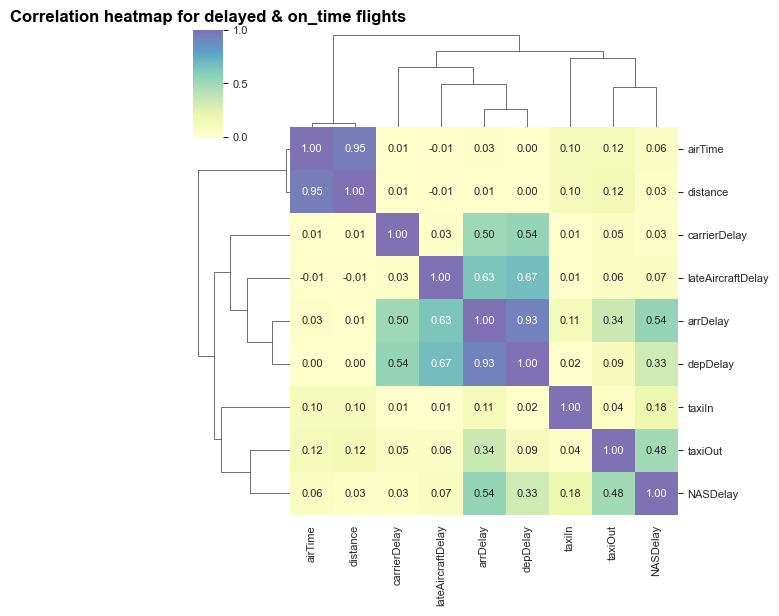

In [70]:
# correlation plot for numeric values of interest using BOTH on_time and delayed flights
sns.clustermap(flights[numeric_vars].corr(), cmap="Spectral", center=0, annot=True, fmt = '.2f', figsize=(6,6), alpha=0.8)
plt.title('Correlation heatmap for delayed & on_time flights')
plt.show()

# reset default plot formatting back
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

<blockquote>
    
**Observations from correlation heatplot:**
- arrDelay and depDelay have strong positive correlation, which we already discovered during univariate exploration
- depDelay have a stronger correlation with carrierDelay and lateAircraftDelay, than arrDelay. Carrier delays and late aircrafts seem to be the main reason for delay in departures
- arrDelay have a stronger correlation with NASDelay than depDelay. NAS seems to be main reason for delays in destinations, possibly challenging to schedule the late arrivals?
- lateAircraft have the strongest correlation with depDelay at 0.67, with carrierDelay a close second at 0.54
- airTime and Distance have a strong positive correlation, which make sense. The longer the flight, the longer we will be in the air.
- taxiOut have a positive stronger correlation with NASDelays than taxiIn, which is an interesting relationship to investigate further.

</blockquote>

In [71]:
# take a sample of all (on_time and delayed) flights to speed up performance
sample = np.random.choice(flights.shape[0], 200000, replace=False)
flight_sample = flights.iloc[sample].copy()

flight_sample = flight_sample[numeric_vars].copy()
flight_sample.fillna(0, inplace=True)

# handle logscale
for col in numeric_vars:
    flight_sample[col] = np.where(flight_sample[col] == 0, 0.9, flight_sample[col])
   
flight_sample.shape

(200000, 9)

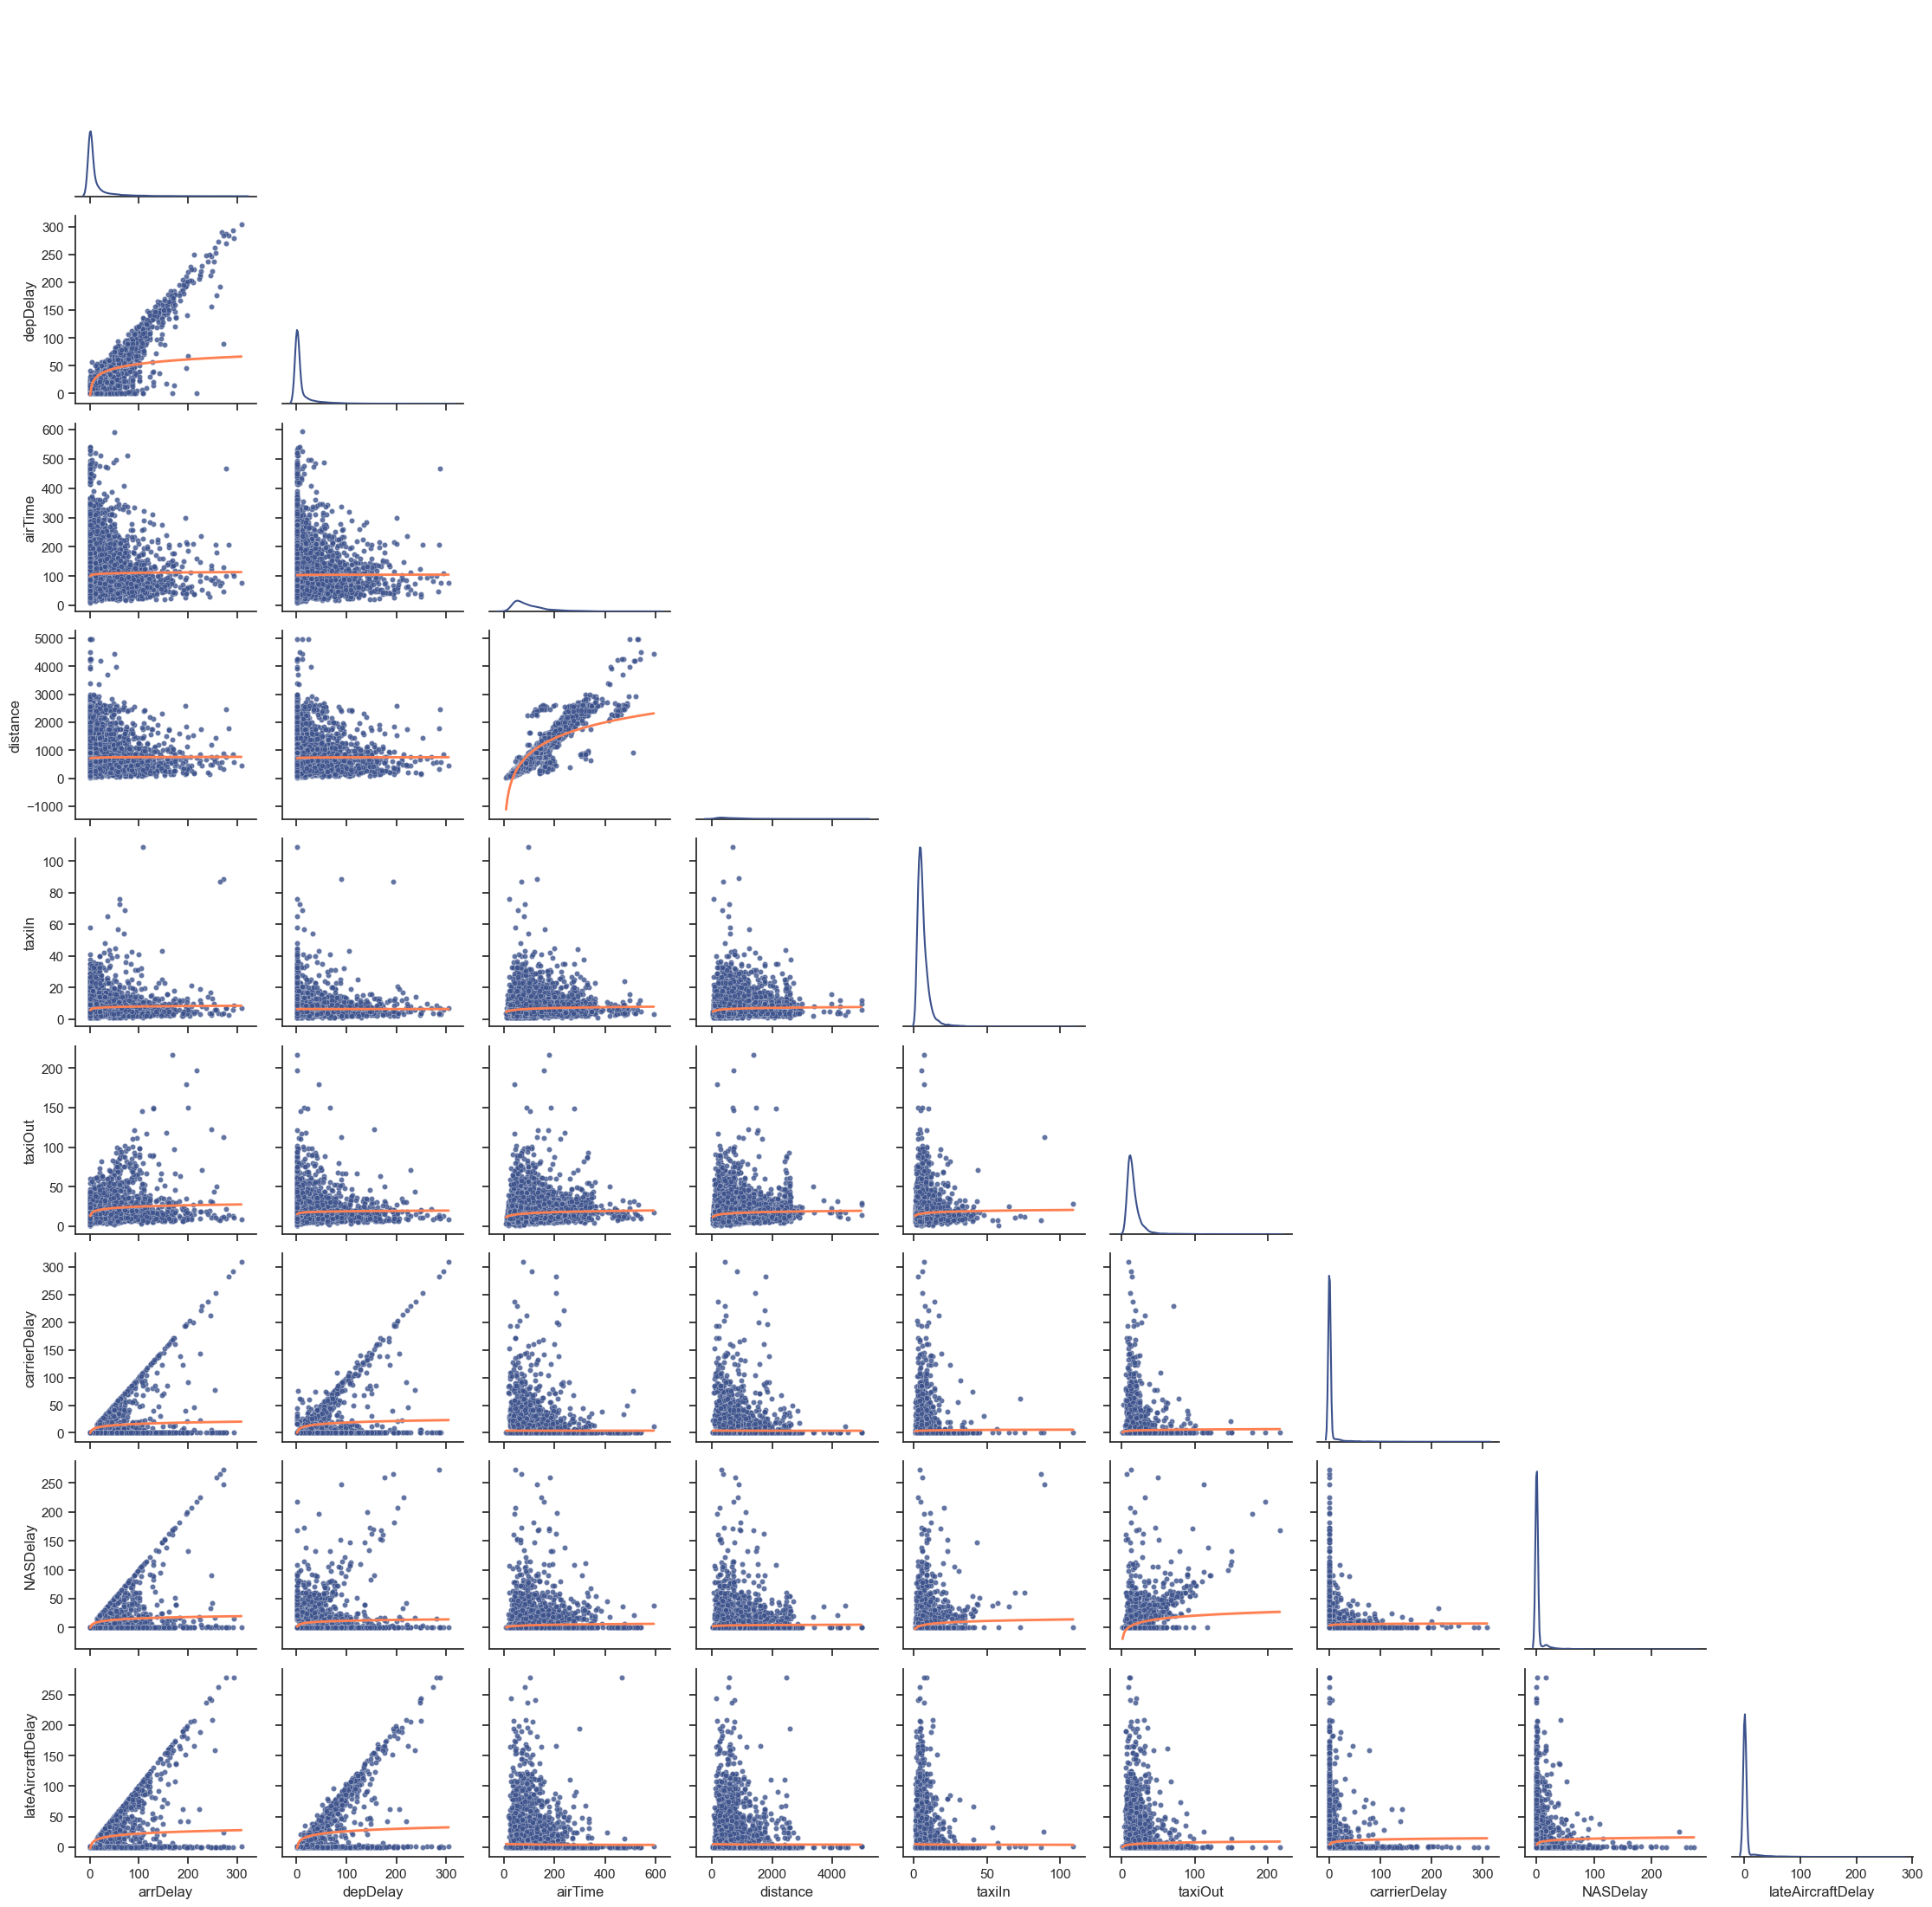

In [72]:
# get another quick overview of the relationships between numeric variables using scatter plots and distributions
sample = np.random.choice(flight_sample.shape[0], 10000, replace=False)
flight_sample_small = flight_sample.iloc[sample].copy()

sns.set(style='ticks')
g = sns.PairGrid(data = flight_sample_small, vars=numeric_vars, corner=True, dropna=True)
g.map_diag(sns.kdeplot, color=BASE_COLOR);
g.map_offdiag(sns.regplot, fit_reg=True, y_jitter=0.1, x_jitter=0.1, truncate=True, logx=True, scatter_kws={'s':20, 'edgecolor':'white', 'lw':0.2}, line_kws={'color': 'coral', 'lw':2}, color=BASE_COLOR)
plt.show()

# reset default plot formatting back
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

<blockquote>

**Observations from heatplot:**

- the log relationship between arrDelay and depDelay indicate that arrival delay increase when departure delay increase, but at a slower rate
- there is an interesting relationship between distance and airtime indicating that as the distance increase, airtime grows as well but also at a slower rate
    
</blockquote>    

<span style="color:blue; font-size:16px; font-family: Calibri;">**Confirm the relationship between departure delay and arrival delay**</span>

To what extend does delays in departure airports cause delays in arrival airports ? Do we make up any lost time during the journey ?

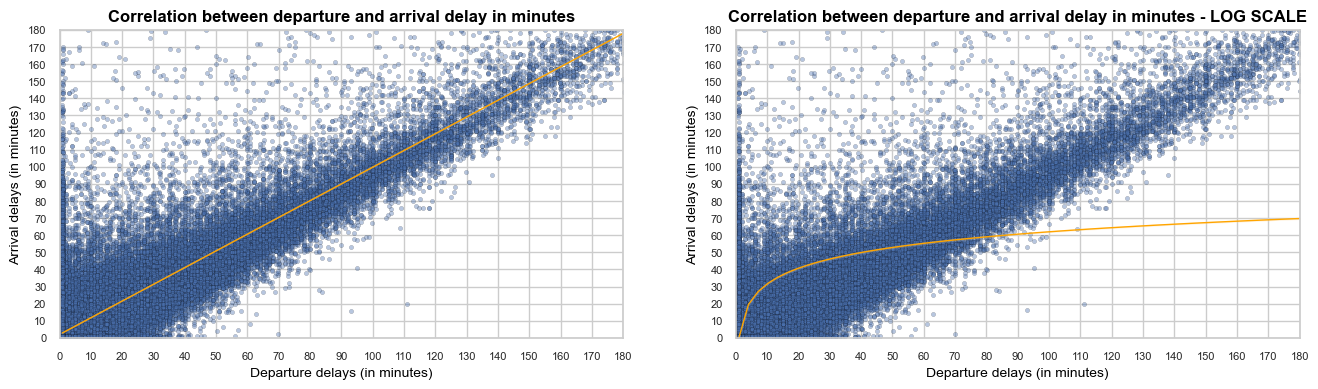

In [73]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4)) 

ticks = np.arange(0, int(flight_sample['arrDelay'].max()+10), 10)

plt.subplot(1,2,1)
sns.regplot(x=flight_sample['depDelay'], y=flight_sample['arrDelay'], y_jitter=0.2, x_jitter=0.2, fit_reg=True, truncate=True, 
            scatter_kws={'alpha':0.4, 's':10, 'edgecolor':'black', 'lw':0.2}, line_kws={'color': 'orange', 'lw':1})
plt.xlabel('Departure delays (in minutes)')
plt.ylabel('Arrival delays (in minutes)')
plt.title('Correlation between departure and arrival delay in minutes')
plt.yticks(ticks, ticks)
plt.xticks(ticks, ticks)
plt.xlim(0,180)
plt.ylim(0,180)

plt.subplot(1,2,2)
sns.regplot(x=flight_sample['depDelay'], y=flight_sample['arrDelay'], fit_reg=True, logx=True, y_jitter=0.2, x_jitter=0.2, truncate=True, 
            scatter_kws={'alpha':0.4, 's':10, 'edgecolor':'black', 'lw':0.2}, line_kws={'color': 'orange', 'lw':1})
plt.xlabel('Departure delays (in minutes)')
plt.ylabel('Arrival delays (in minutes)')
plt.title('Correlation between departure and arrival delay in minutes - LOG SCALE')
plt.yticks(ticks, ticks)
plt.xticks(ticks, ticks)
plt.xlim(0,180)
plt.ylim(0,180)

plt.show()

>When departure delay increase, arrival delay increase as well but at a slower rate. Is this an indicator that we can make up for lost time during our journey. If so, how does distance and airtime play a role?

<span style="color:blue; font-size:16px; font-family: Calibri;">**Confirm the relationship between airtime and distance**</span>

As the distance increase, does the airtime increase proportionally, or do we make up for lost time during the flight?

/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_1281/882253735.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2, sharex=ax, sharey=ax)


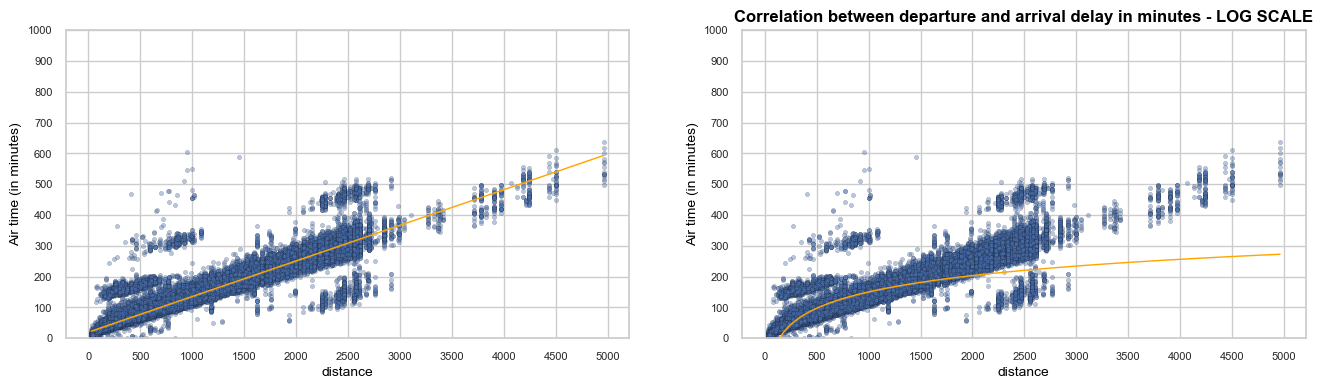

In [74]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4)) 

xticks = np.arange(0, 5500, 500)
yticks = np.arange(0, 1100, 100)

ax = plt.subplot(1,2,1)
sns.regplot(x=flight_sample['distance'], y=flight_sample['airTime'], y_jitter=0.2, x_jitter=0.2, fit_reg=True, truncate=True, scatter_kws={'alpha':0.4, 's':10, 'edgecolor':'black', 'lw':0.2}, line_kws={'color': 'orange', 'lw':1})
plt.xticks(xticks, xticks)
plt.yticks(yticks, yticks)
plt.ylim(0,1000)
plt.xlabel('distance')
plt.ylabel('Air time (in minutes)')

plt.subplot(1,2,2, sharex=ax, sharey=ax)
sns.regplot(x=flight_sample['distance'], y=flight_sample['airTime'], fit_reg=True, logx=True, y_jitter=0.2, x_jitter=0.2, truncate=True, scatter_kws={'alpha':0.4, 's':10, 'edgecolor':'black', 'lw':0.2}, line_kws={'color': 'orange', 'lw':1})
plt.xlabel('distance')
plt.ylabel('Air time (in minutes)')
plt.title('Correlation between departure and arrival delay in minutes - LOG SCALE')

plt.show()

>There is an indeed interesting relationship between distance and airtime indicating that as the distance increase, airtime grows as well but at a slower rate. We have an opportunity to make-up for some lost time

<span style="color:blue; font-size:16px; font-family: Calibri;">**Let's put above facts together... Does the relationship between depDelay, arrDelay and airTime show us a delay catch-up time trend ?**</span>

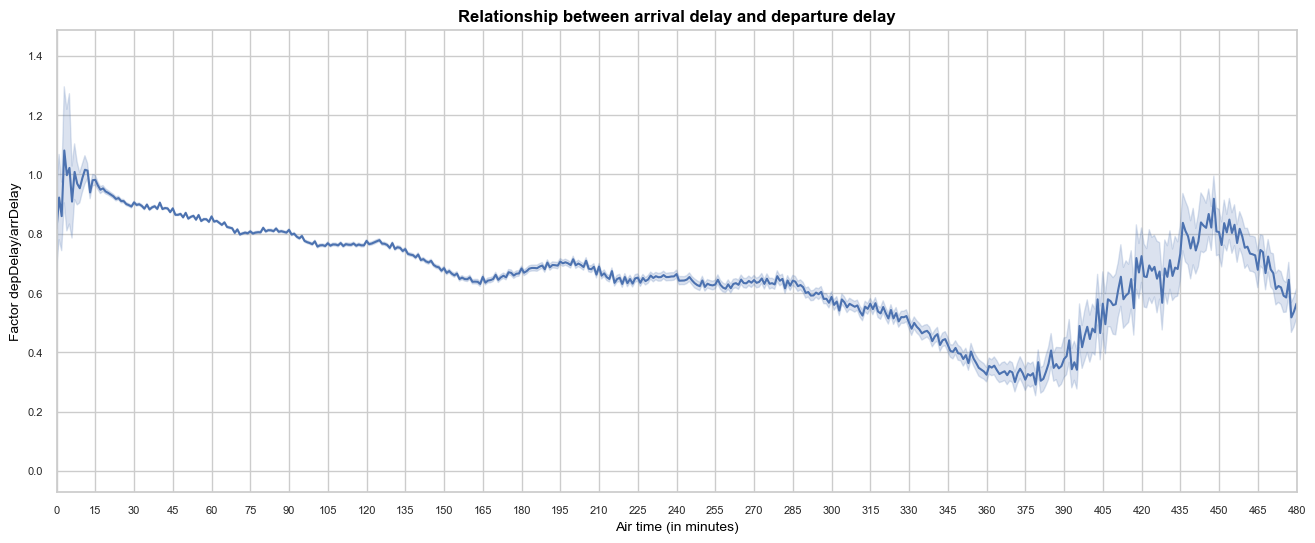

In [75]:
# observe trend of arrival vs departure delay for max 12 hours flight
xticks = np.arange(0, 12*60+15, 15)
plt.figure(figsize=(16,6))
sns.lineplot(data=flights, x='airTime', y=flight_delays['depDelay']/flight_delays['arrDelay'])
plt.xticks(xticks, xticks)
plt.xlim(0,480)
plt.xlabel('Air time (in minutes)')
plt.ylabel('Factor depDelay/arrDelay')
plt.title('Relationship between arrival delay and departure delay')
plt.show()

>We see a lot fluctuation during the first 15 minutes of the airTime, as we are not yet on full speed during take-off and thus have not much time catch-up opportunity. 
>There is a clear downwards trend of factor departure delay / arrival delay from 15 - 375 minutes, where we have the most opportunity for catch-up.

<a id='bivariate_categorical'></a>
### Categorical exploration

<span style="color:blue; font-size:16px; font-family: Calibri;">**What is the relationship between carriers and the departure airports they serve ?**</span>

Explore the relationship using the same top carriers and departure airports that cause delays during univariate exploration, and plot the relationship between top 30 biggest players

In [76]:
# get top 30 carriers causing delays
top_carrier = list(cat_carrier['uniqueCarrier'][:30])

In [77]:
# get top departure airports causing delays
top_origin = list(origin['origin'][:30])

In [78]:
# get top lanes causing delays
top_lane = list(lanes.index[:30])

In [79]:
# filter flights dataset on the top 30 airports and carriers causing the most delays
df_heatmap_top30 = flights[['uniqueCarrier', 'origin', 'lane', 'depDelay', 'carrierDelay', 'lateAircraftDelay', 'NASDelay']].copy()
df_heatmap_top30 = df_heatmap_top30.loc[(df_heatmap_top30['uniqueCarrier'].isin(top_carrier))]
df_heatmap_top30 = df_heatmap_top30.loc[(df_heatmap_top30['origin'].isin(top_origin))]

In [80]:
# Focus only on frequent flying carrier/origin combinations where number of flights exceed at least 200 for the 4 year period
df_heatmap_exclude = df_heatmap_top30.groupby(['uniqueCarrier', 'origin']).size().reset_index().rename(columns={0:'count'})
df_heatmap_exclude = df_heatmap_exclude[df_heatmap_exclude['count'] < 200]

df_heatmap_top30 = pd.merge(df_heatmap_top30, df_heatmap_exclude, on=['uniqueCarrier', 'origin'], how='outer', indicator=True)
df_heatmap_top30 = df_heatmap_top30.loc[df_heatmap_top30['_merge'] == 'left_only'].drop(['_merge', 'count'], axis=1)

In [81]:
# creat heatmap
df_heatmap_depDelay = df_heatmap_top30.pivot_table(values='depDelay',index='uniqueCarrier',columns='origin', aggfunc=np.mean, sort=False)

# first reorder origin airports from low to high mean delays
df_heatmap_depDelay = df_heatmap_depDelay.loc[:, df_heatmap_depDelay.max().sort_values().index]

# then reorder carriers from low to high mean delays
df_heatmap_depDelay = df_heatmap_depDelay.loc[df_heatmap_depDelay.max(axis=1).sort_values().index, :]

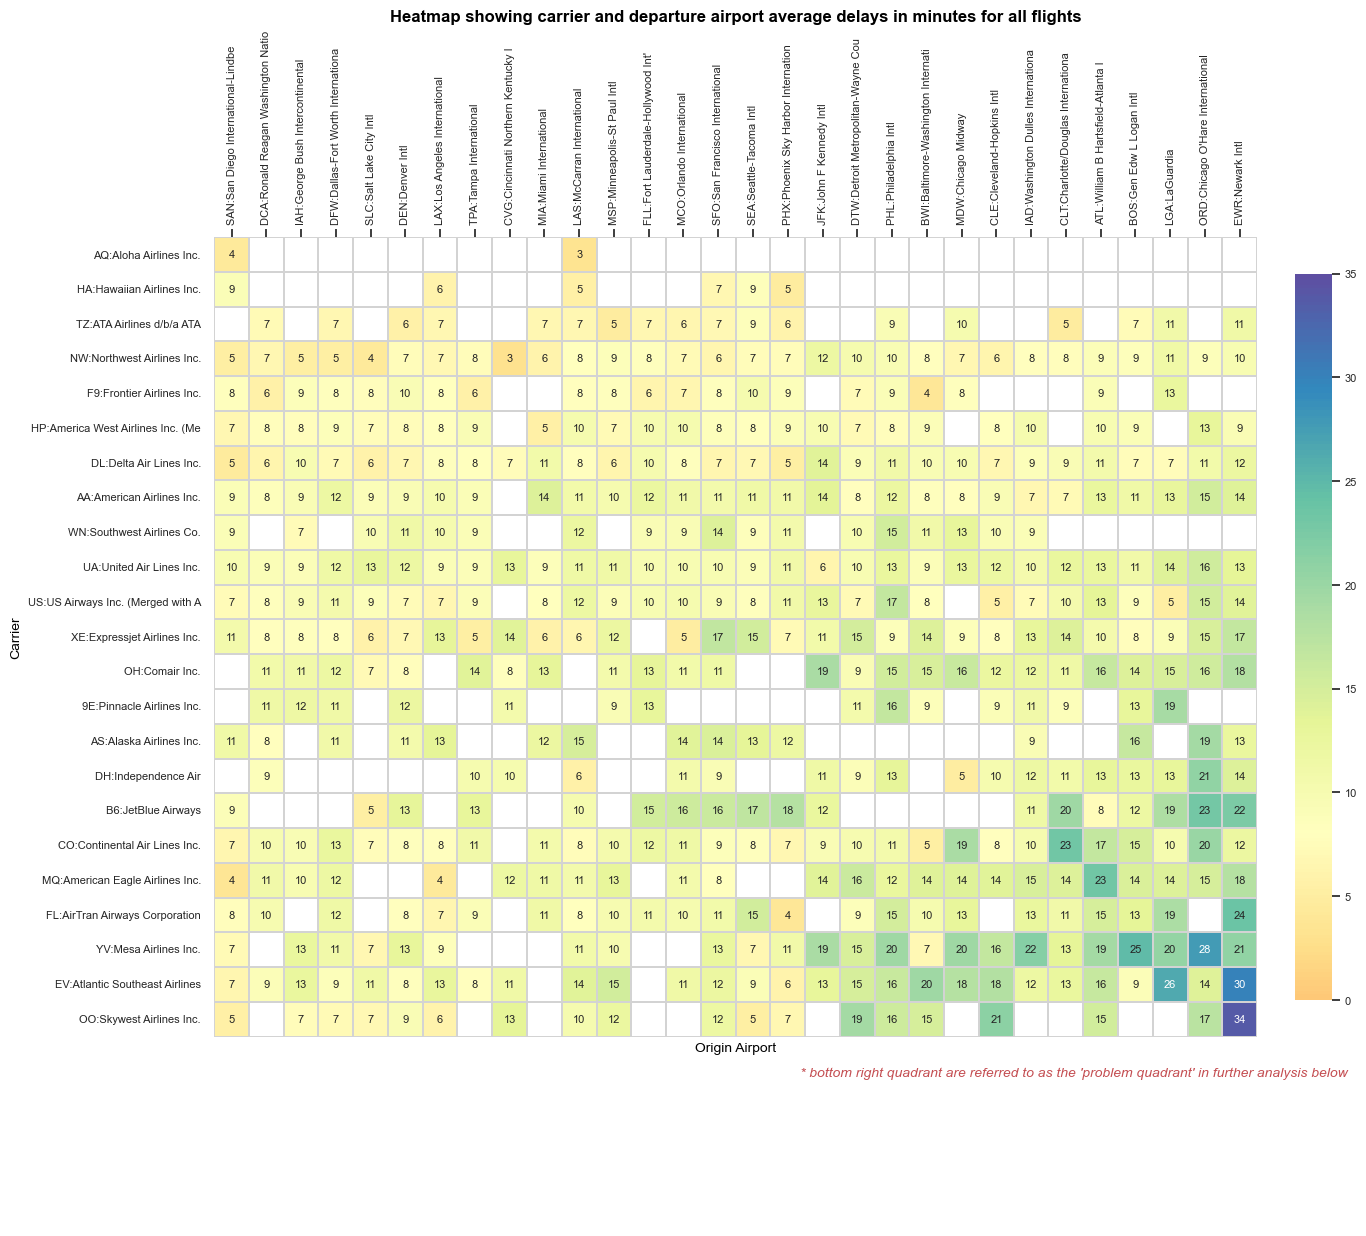

In [82]:
# plot carrier/departure airport heatmap
plt.figure(figsize = [15,15])

g = sns.heatmap(df_heatmap_depDelay, center=8, cmap='Spectral', linewidths=0.1, linecolor='lightgrey', square=True, mask=df_heatmap_depDelay <= 0, 
                annot=True, fmt=".0f", vmax=35, vmin=0, cbar_kws={"orientation": "vertical", "pad": 0.03, "shrink": 0.5})

# add descriptions to xticks
xticks = g.get_xticks()
xlabels = []
locs, labels = plt.xticks()
for loc, label in zip(locs,labels):  
    city = '{}:{}'.format(label.get_text(), airports.loc[label.get_text()]['airport'][:30])
    xlabels.append(city)
plt.xticks(xticks, xlabels, rotation=90)

# add descriptions to yticks
yticks = g.get_yticks()
ylabels = []
locs, labels = plt.yticks()
for loc, label in zip(locs,labels):  
    carrier = '{}:{}'.format(label.get_text(), carriers.loc[label.get_text()]['carrier_description'][:30])
    ylabels.append(carrier)
plt.yticks(yticks, ylabels, rotation=360)

# put xlabels on top
plt.title('Heatmap showing carrier and departure airport average delays in minutes for all flights')
g.set(xlabel=" ", ylabel=" ")
g.xaxis.tick_top()



# add footnote figure reference, as this plot will become the main reference for further analysis
footnote = "* bottom right quadrant are referred to as the 'problem quadrant' in further analysis below"
plt.text(s = footnote,
         x = 0.5,
         y = 0.4,
         fontname = 'Arial',
         fontstyle = 'italic',
         fontsize = 10,
         ha = 'left',
         color ='r',
         transform = fig.transFigure)



plt.xlabel('Origin Airport')
plt.ylabel('Carrier')
plt.tight_layout()
plt.show()

<blockquote>
    
- Left side of heat plot have lower average delays than right side of the heat plot. 
- The bottom right quadrant contains the carriers and airport combinations with the most delays, the **darker green/blue area is clearly distinguishable**.
- Overall the top carriers that were flagged in Univariate anayisis (e.g. AA, WN, DL), that are also the biggest airlines, have lower average but consistant delays, accross all airports and appear in the top half of the heat plot
- Departure airports on watch flagged in Univariate analysis (ATL, ORD, EWR, JFK, PHL) are positioned on the right of the heatplot. However these airports are not doing consistantly 'bad', carriers in the top right quadrant are still doing well at these airports.
- It seems that the smaller/mid carriers like YV, B6 have more delays at the larger airports
- The fact that the same carriers does well at airports in left quadrant, but worse at these airports on the right, indicate it must be a carrier/location combination where some carriers might have lower priority at some airports? JetBlue, according  to wikipedia is a budget airline, and Mesa have financial difficulties. These are smaller carriers.

</blockquote>

<span style="color:blue; font-size:16px; font-family: Calibri;">**What are top reasons for these higher than average delays in the bottom right ('problem') quadrant of the heatmap? Is it the carrier or airport at fault ?**</span>

#### Let's zoom into the *problem* quadrant where carrier/airport combinations cause the biggest delays. Can we identify  the reasons why these specific carrier/airports combinations are different?

Prepare new datasets to analyse different combinations of carrier/airport with reasons for delay

In [83]:
# get the carriers and airports combinations in the same sequence as in heatmap, from low to high average total delays
problem_carrier = [label.split(':')[0] for label in ylabels] 
problem_airport = [label.split(':')[0] for label in xlabels] 
problem_carrier_description = ylabels
problem_airport_description = xlabels 

In [84]:
# select the 'best' and 'worse' carrier/airport combinations in the same sequence as in heatmap, so we can compare them
# for 'best', select the 4 largest airlines that does well accross all airports

topn_best_worse = 8
problem_carrier_best_worse = problem_carrier[5:10] + problem_carrier[topn_best_worse*-1:] 
problem_airport_best_worse = problem_airport[5:10] + problem_airport[topn_best_worse*-1:]  
problem_carrier_description_best_worse = ylabels[5:10] + ylabels[topn_best_worse*-1:]
problem_airport_description_best_worse = xlabels[5:10] + xlabels[topn_best_worse*-1:]

# create dataset with best and worse carrier/airport combinations using heatmap above as base
df_heatmap_topn_best_worse = df_heatmap_top30[['uniqueCarrier', 'origin', 'carrierDelay', 'lateAircraftDelay', 'NASDelay']].copy()
df_heatmap_topn_best_worse = df_heatmap_topn_best_worse.loc[(df_heatmap_topn_best_worse['uniqueCarrier'].isin(problem_carrier_best_worse))]
df_heatmap_topn_best_worse = df_heatmap_topn_best_worse.loc[(df_heatmap_topn_best_worse['origin'].isin(problem_airport_best_worse))]

In [85]:
# get the problem quadrant only, select the 'worst' carrier/airport combinations in the same sequence as in heatmap, so we can compare them
topn_worse = 10
problem_carrier_worse = problem_carrier[topn_worse*-1:]
problem_airport_worse = problem_airport[topn_worse*-1:]
problem_carrier_description_worse = ylabels[topn_worse*-1:]
problem_airport_description_worse = xlabels[topn_worse*-1:]

# create dataset focussing only on the worse carrier/airport combinations in the bottom right quadant of the heatmap above
df_heatmap_topn_worse = df_heatmap_top30[['uniqueCarrier', 'origin', 'carrierDelay', 'lateAircraftDelay', 'NASDelay']].copy()
df_heatmap_topn_worse = df_heatmap_topn_worse.loc[(df_heatmap_topn_worse['uniqueCarrier'].isin(problem_carrier_worse))]
df_heatmap_topn_worse = df_heatmap_topn_worse.loc[(df_heatmap_topn_worse['origin'].isin(problem_airport_worse))]

In [86]:
# aggregate new datasets from different angles to analyze reason for delays
f = {'carrierDelay':np.mean, 'lateAircraftDelay':np.mean, 'NASDelay':np.mean}
df_heatmap_topn_best_worse = df_heatmap_topn_best_worse.groupby(['uniqueCarrier', 'origin'], as_index=False).agg(f)
df_heatmap_topn_worse = df_heatmap_topn_worse.groupby(['uniqueCarrier', 'origin'], as_index=False).agg(f)
df_heatmap_top30_agg = df_heatmap_top30.groupby(['uniqueCarrier', 'origin'], as_index=False).agg(f)

#### Lets first look at the airports in the heatmap, and their reasons for delay

In [87]:
df_heatmap_reason = df_heatmap_top30_agg.melt(id_vars=['uniqueCarrier', 'origin'], var_name='delay_reason', value_name='delay')
df_heatmap_reason = df_heatmap_reason.groupby(['uniqueCarrier', 'origin', 'delay_reason'], as_index=False)['delay'].agg(np.mean)

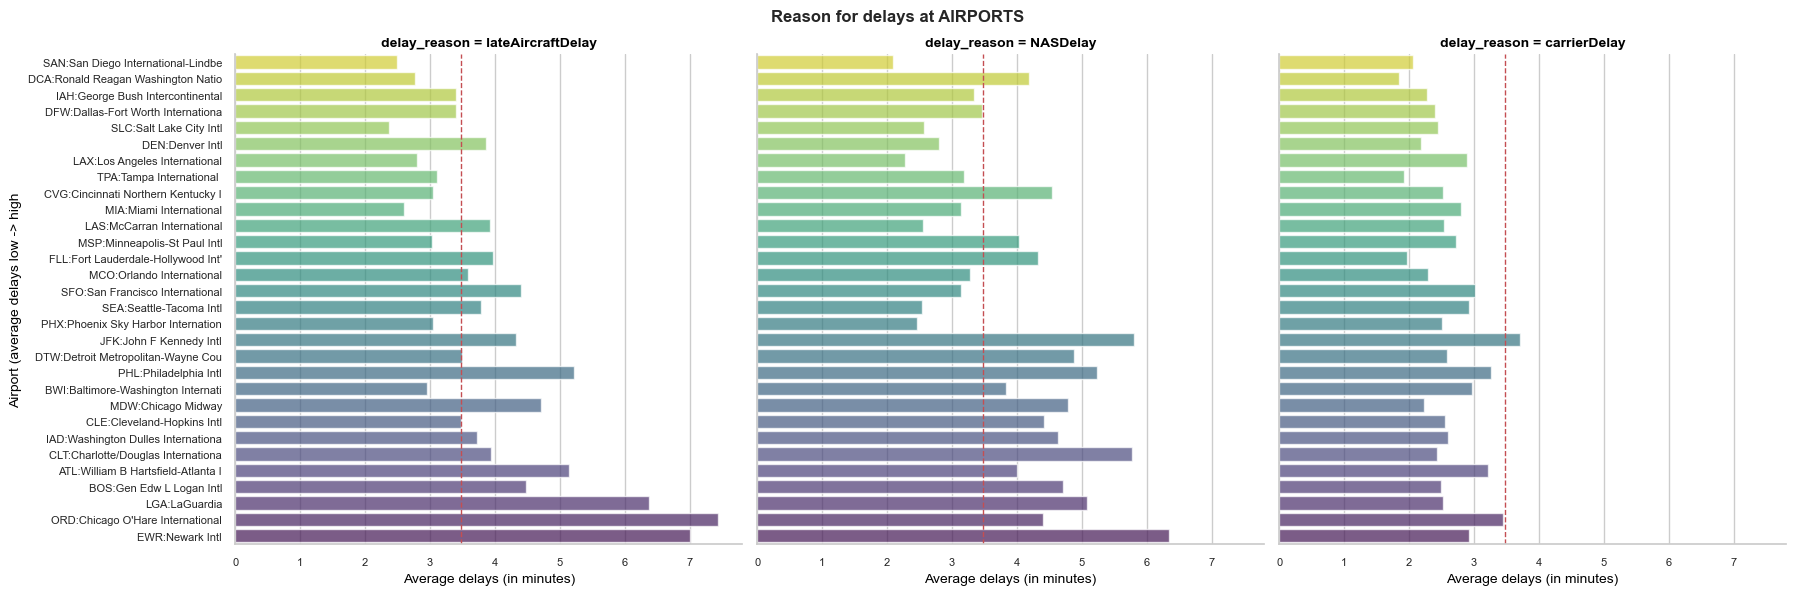

In [88]:
g = sns.FacetGrid(data = df_heatmap_reason, col='delay_reason', height=6, aspect=1, col_order=['lateAircraftDelay', 'NASDelay', 'carrierDelay'], despine=True)
g.map_dataframe(sns.barplot, y='origin', x='delay', errorbar=None, order=problem_airport, palette='viridis_r', alpha=0.7)
g.refline(x=df_heatmap_reason["delay"].mean(), linewidth=1, color='r')

plt.suptitle('Reason for delays at AIRPORTS')
g.set_yticklabels(labels=problem_airport_description)
g.set_axis_labels("Average delays (in minutes)", "Airport (average delays low -> high")

plt.tight_layout()
plt.show()

>- Airports in the bottom right of the quadrant of the heatmap (bottom in the graph above), have above average late aircraft and NAS delays. EWR, ORD, LGA especially stands out for high late aircrafts, whereas EWR, CLT, PHX have the highest NAS delays
>- Carrier delays happens across all airports fairly consistantly, where PHX are SLIGHTLY above average.

#### Lets first look at the carriers in the heatmap, and their reasons for delay

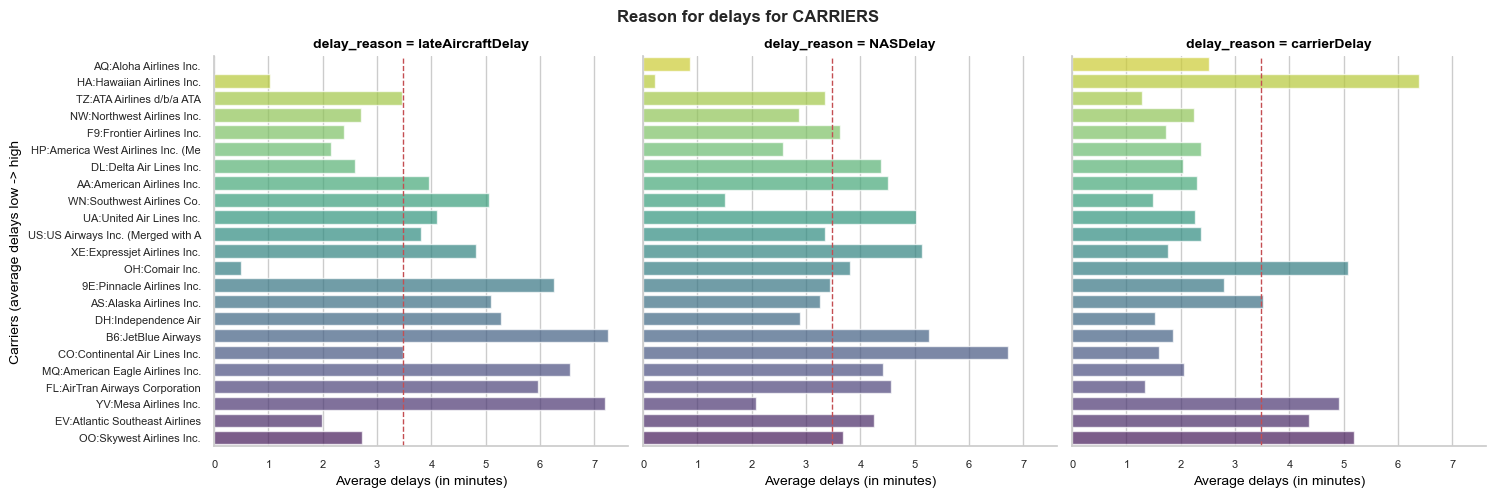

In [89]:
g = sns.FacetGrid(data = df_heatmap_reason, col='delay_reason', height=5, aspect=1, margin_titles=False, col_order=['lateAircraftDelay', 'NASDelay', 'carrierDelay'])
g.map_dataframe(sns.barplot, y='uniqueCarrier', x='delay', errorbar=None, order=problem_carrier, palette='viridis_r', alpha=0.7)
g.refline(x=df_heatmap_reason["delay"].mean(), linewidth=1, color='r')

plt.suptitle('Reason for delays for CARRIERS')
g.set_yticklabels(labels=problem_carrier_description)
g.set_axis_labels("Average delays (in minutes)", "Carriers (average delays low -> high")

plt.tight_layout()
plt.show()

>- At carrier level, we see the same pattern as at airports above, late aircarft delay being the main reason for delays, whilst carrier delays are often higher than NAS delays.
>- For CO, there seems to be exceptionally large NAS delays
>- For OO, YV, EV, OH and HA carrier delays seems larger, which are more the mid to smaller carrieres

<a id='bivariate_timeseries'></a>
### Time series exploration

<span style="color:blue; font-size:16px; font-family: Calibri;">**Does the top 30 carriers with most total delays show the same  summer/xmas seasonal pattern we observed univariate analysis?**</span>

In [90]:
# build a timeseries dataset with datatime field as index
flight_timeseries_day_origin = flights.groupby(['origin', 'uniqueCarrier', 'date'])['flight_status'].value_counts().unstack()
flight_timeseries_day_origin.reset_index(inplace=True)
flight_timeseries_day_origin.set_index('date', inplace=True)
flight_timeseries_day_origin = flight_timeseries_day_origin.loc[flight_timeseries_day_origin['origin'].isin(problem_airport_best_worse)]
flight_timeseries_day_origin = flight_timeseries_day_origin.loc[flight_timeseries_day_origin['uniqueCarrier'].isin(problem_carrier_best_worse)]

flight_timeseries_day_origin = flight_timeseries_day_origin.groupby(['origin', 'uniqueCarrier']).resample('M').sum(numeric_only=True)
flight_timeseries_day_origin.reset_index(inplace=True)

flight_timeseries_day_origin['prop'] = flight_timeseries_day_origin['delayed'] / (flight_timeseries_day_origin['delayed'] + flight_timeseries_day_origin['on_time'])
flight_timeseries_month.fillna(0, inplace=True)
flight_timeseries_day_origin.head()

flight_status origin uniqueCarrier       date  delayed  on_time      prop
0                ATL            AA 2003-01-31    109.0    644.0  0.144754
1                ATL            AA 2003-02-28    138.0    535.0  0.205052
2                ATL            AA 2003-03-31    116.0    636.0  0.154255
3                ATL            AA 2003-04-30    120.0    614.0  0.163488
4                ATL            AA 2003-05-31    174.0    573.0  0.232932

In [91]:
# create an overall average base using all data
flight_timeseries_month['prop'] = flight_timeseries_month['delayed'] / (flight_timeseries_month['delayed'] + flight_timeseries_month['on_time'])
flight_timeseries_month.fillna(0, inplace=True)

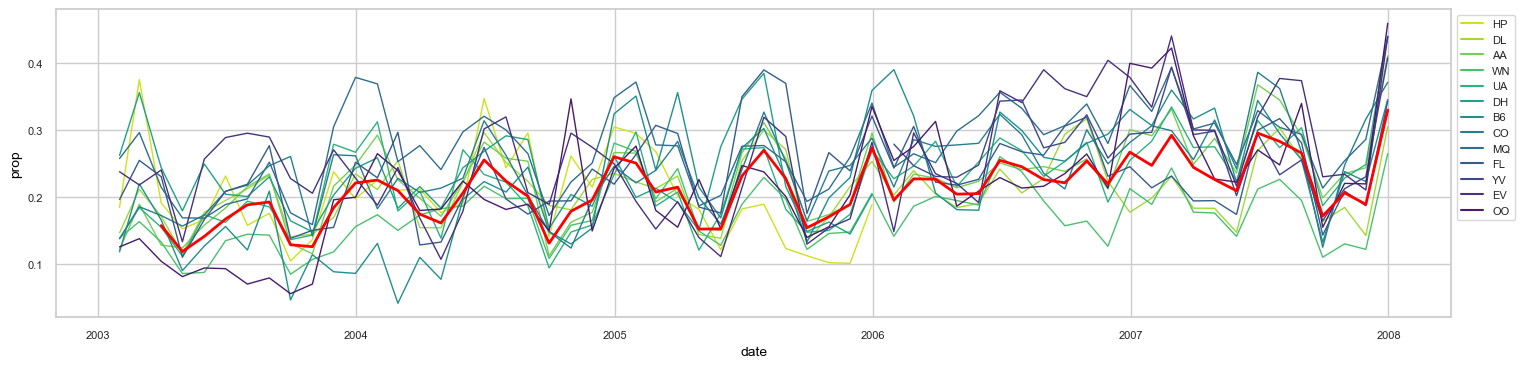

In [92]:
plt.figure(figsize = (18,4))
sns.lineplot(data=flight_timeseries_day_origin, x='date', y='prop', hue='uniqueCarrier', errorbar=None, linewidth=1, hue_order=problem_carrier_best_worse, palette='viridis_r')
sns.lineplot(data=flight_timeseries_month['prop'], color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
plt.show()

<blockquote>

Indeed, the same seasonal pattern are visible for the top 30 *carriers* with most delays. We can observe mostly dark green to blue lines above the red mean line, and light green to yellow lines near or below the read mean line, confirming those carriers in the bottom right quadrant have seasonal delays above average.
    
</blockquote>    

<span style="color:blue; font-size:16px; font-family: Calibri;">**Does the top 30 origin airports with most total delays show the same  summer/xmas seasonal pattern we observed univariate analysis?**</span>

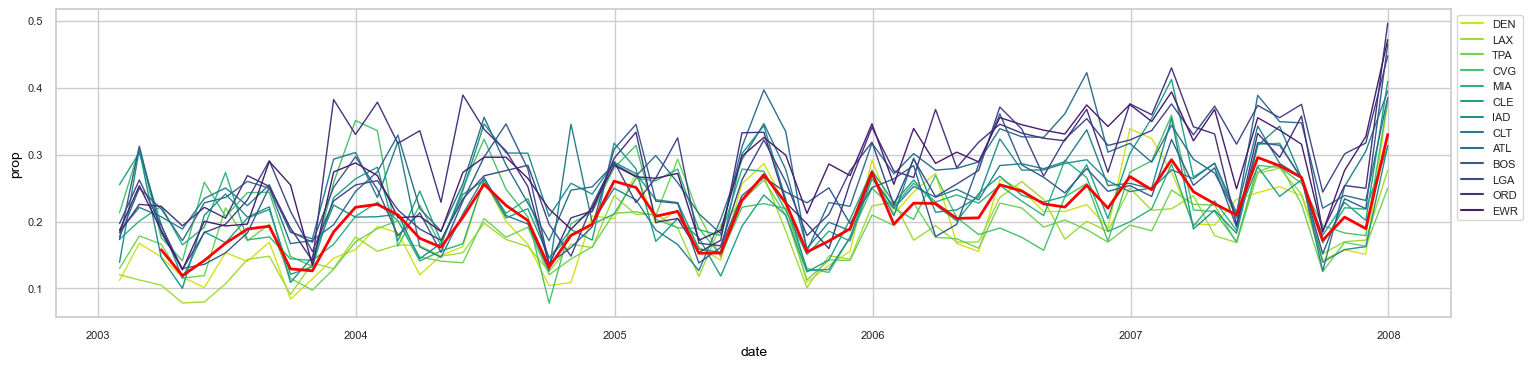

In [93]:
plt.figure(figsize = (18,4))
sns.lineplot(data=flight_timeseries_day_origin, x='date', y='prop', hue='origin', errorbar=None, linewidth=1, hue_order=problem_airport_best_worse, palette='viridis_r')
sns.lineplot(data=flight_timeseries_month['prop'], color='red', linewidth=2)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
plt.show()

<blockquote>

Indeed, the same seasonal pattern are visible for the top 30 *airlines* with most delays. We can observe mostly dark green to blue lines above the red mean line, and light green to yellow lines near or below the read mean line, confirming those airports in the bottom right quadrant have generally seasonal delays above average.

The seasonal pattern accross airports are more consistent, with yellow and light green lines below the mean red line, and darker green and blue lines above the mean read lines. With carriers, this pattern is visible, but are more distorted.
    
</blockquote>    

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

<blockquote>

**Numerical exploration**        

- arrDelay and depDelay have strong positive correlation, which we already discovered during univariate exploration
- depDelay have a stronger correlation with carrierDelay and lateAircraftDelay, than arrDelay. Carrier delays and late aircrafts seem to be the main reason for delay in departures
- arrDelay have a stronger correlation with NASDelay than depDelay have with NASDelay. NAS seems to be main reason for delays in destinations, possibly challenging to schedule the late arrivals?

- the log relationship between arrDelay and depDelay indicate that arrival delay grows slower as departure delay increase. When departure delay increase, arrival delay increase as well but at a lower rate. 
   
We have the most opportunity to minimize departure delays from 15 - 375 minutes flying time
  
**Categorical exploration**                            

- Of the top 30 carriers and airports causing the highest average delays, there is a specific combination of carriers/airports falling into the bottom right quadrant on the heatmap above, that cause higher that average delays.

- The fact that:
    - the same carriers that does well at airports in left quadrants, are doing worse at those airports on the right quadrant, makes one believe it's an airport issue
    - the same airports does consistently well for the carriers in the top quadrants, but worse for those carriers on the bottom right, makes one believe it's an carrier issue

- Is there a special relationship specific to those carrier/airport combinations that cause worse delays than the norm? Let's further investigate that in multivariate exploration
    
**Time Series exploration:** 
 
    
- Carriers and departure airports in the bottom right quadrant of the heatmap follow the same seasonal pattern observed in univariate exploration and consistently have delays above average

    
</blockquote>

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

<blockquote>
    
- taxiOut have a positive stronger correlation with NASDelays than taxiIn, which is an interesting relationship to investigate further.
- airTime and Distance have a strong positive correlation, which make sense. The longer the flight, the longer we will be in the air. As the distance increase, airtime grows as well but at a slower rate, suggesting the longer the distance, the faster we fly, thus airTime is not as long as we would expect.
- If carrierDelay or lateAircraftDelay goes down, NASDelay goes up, this is a strange relationship.
    
</blockquote>

<a id='multivariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 3: Multivariate Exploration</span>

In [94]:
# clear the garbage to free memory
gc.collect()

13299

<span style="color:blue; font-size:16px; font-family: Calibri;">**What are top reasons for these higher than average delays in the heatmap bottom right quadrant ? Is it the carrier or airport at fault ?**</span>

#### Lets look at combination of carrier and airport in the *problem quadrant* 

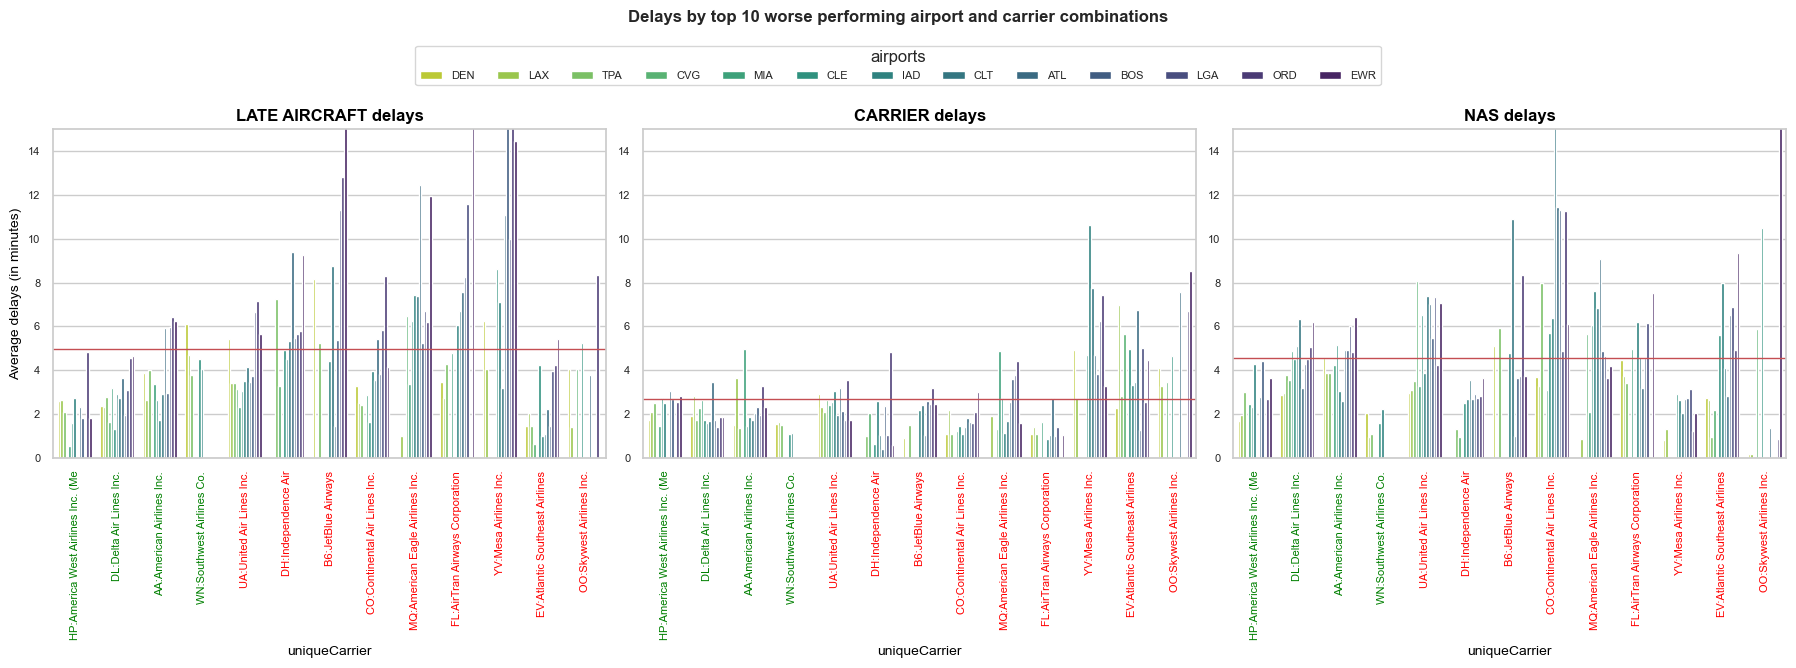

In [95]:
plt.figure(figsize = [18,6])

ax1 = plt.subplot(1,3,1)
sns.barplot(data=df_heatmap_topn_best_worse, x='uniqueCarrier', y='lateAircraftDelay', hue='origin', order=problem_carrier_best_worse, hue_order=problem_airport_best_worse, 
            palette='viridis_r')
plt.axhline(y=df_heatmap_topn_best_worse['lateAircraftDelay'].mean(), color='r', linewidth=1)
plt.ylabel('Average delays (in minutes)')
xticks = ax1.get_xticks()
# ax1.tick_params(axis='x', colors=['red', 'blue'])
plt.xticks(xticks, problem_carrier_description_best_worse, rotation=90)
plt.title('LATE AIRCRAFT delays')
plt.figlegend(bbox_to_anchor=(0.5, 1.05), loc = 'upper center', title='airports', fancybox=True, ncol=len(problem_airport_best_worse))
plt.legend().set_visible(False)
plt.ylim(0,15)

# indicate which carriers are performing above and below average by setting xtick label to green or red
for ax in plt.gca().get_xticklabels()[:4]:
    ax.set_color('green')
    
for ax in plt.gca().get_xticklabels()[4:]:
    ax.set_color('red')


plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
sns.barplot(data=df_heatmap_topn_best_worse, x='uniqueCarrier', y='carrierDelay', hue='origin', order=problem_carrier_best_worse, hue_order=problem_airport_best_worse, palette='viridis_r')
plt.axhline(y=df_heatmap_topn_best_worse['carrierDelay'].mean(), color='r', linewidth=1)
plt.legend().set_visible(False)
plt.ylabel('')
plt.xticks(xticks, problem_carrier_description_best_worse, rotation=90)
plt.title('CARRIER delays')

# indicate which carriers are performing above and below average by setting xtick label to green or red
for ax in plt.gca().get_xticklabels()[:4]:
    ax.set_color('green')
    
for ax in plt.gca().get_xticklabels()[4:]:
    ax.set_color('red')


plt.subplot(1,3,3, sharex=ax1, sharey=ax1)
sns.barplot(data=df_heatmap_topn_best_worse, x='uniqueCarrier', y='NASDelay', hue='origin', order=problem_carrier_best_worse, hue_order=problem_airport_best_worse, palette='viridis_r')
plt.axhline(y=df_heatmap_topn_best_worse['NASDelay'].mean(), color='r', linewidth=1)
plt.ylabel('')
plt.xticks(xticks, problem_carrier_description_best_worse, rotation=90)
plt.title('NAS delays')
plt.legend().set_visible(False)

# indicate which carriers are performing above and below average by setting xtick label to green or red
for ax in plt.gca().get_xticklabels()[:4]:
    ax.set_color('green')
    
for ax in plt.gca().get_xticklabels()[4:]:
    ax.set_color('red')

plt.suptitle('Delays by top 10 worse performing airport and carrier combinations', y=1.1)

plt.tight_layout()
plt.show()

- Generally carriers on the right have higher delays accross all delay reasons in multiple airports:

    - Late aircraft delays are happening the most frequently for carriers on the right, especially for YV, FL, MQ, B6 across many airports.
    - Carrier delays are the most common for carriers on the far right, (OO, EV, YV) accross different airports
    - NAS delays in EWR for carrier OO seems to be a huge problem
    - NAS problems happen the most frequently across airports for carriers EV, FL, MQ, B6 and CO

#### Create heatmap for each reason for delay to get a clearer picture of relationships

In [96]:
df_heatmap_lateAircraftDelay = df_heatmap_topn_worse.pivot_table(values='lateAircraftDelay',index='uniqueCarrier',columns='origin', aggfunc=np.mean, sort=False)
df_heatmap_lateAircraftDelay = df_heatmap_lateAircraftDelay.loc[:, df_heatmap_lateAircraftDelay.max().sort_values().index]
df_heatmap_lateAircraftDelay = df_heatmap_lateAircraftDelay.loc[df_heatmap_lateAircraftDelay.max(axis=1).sort_values().index, :]
df_heatmap_lateAircraftDelay.fillna(0, inplace=True)

In [97]:
df_heatmap_carrierDelay = df_heatmap_topn_worse.pivot_table(values='carrierDelay',index='uniqueCarrier',columns='origin', aggfunc=np.mean, sort=False)
df_heatmap_carrierDelay = df_heatmap_carrierDelay.loc[:, df_heatmap_carrierDelay.max().sort_values().index]
df_heatmap_carrierDelay = df_heatmap_carrierDelay.loc[df_heatmap_carrierDelay.max(axis=1).sort_values().index, :]
df_heatmap_carrierDelay.fillna(0, inplace=True)

In [98]:
df_heatmap_NASDelay = df_heatmap_topn_worse.pivot_table(values='NASDelay',index='uniqueCarrier',columns='origin', aggfunc=np.mean, sort=False)
df_heatmap_NASDelay = df_heatmap_NASDelay.loc[:, df_heatmap_NASDelay.max().sort_values().index]
df_heatmap_NASDelay = df_heatmap_NASDelay.loc[df_heatmap_NASDelay.max(axis=1).sort_values().index, :]
df_heatmap_NASDelay.fillna(0, inplace=True)

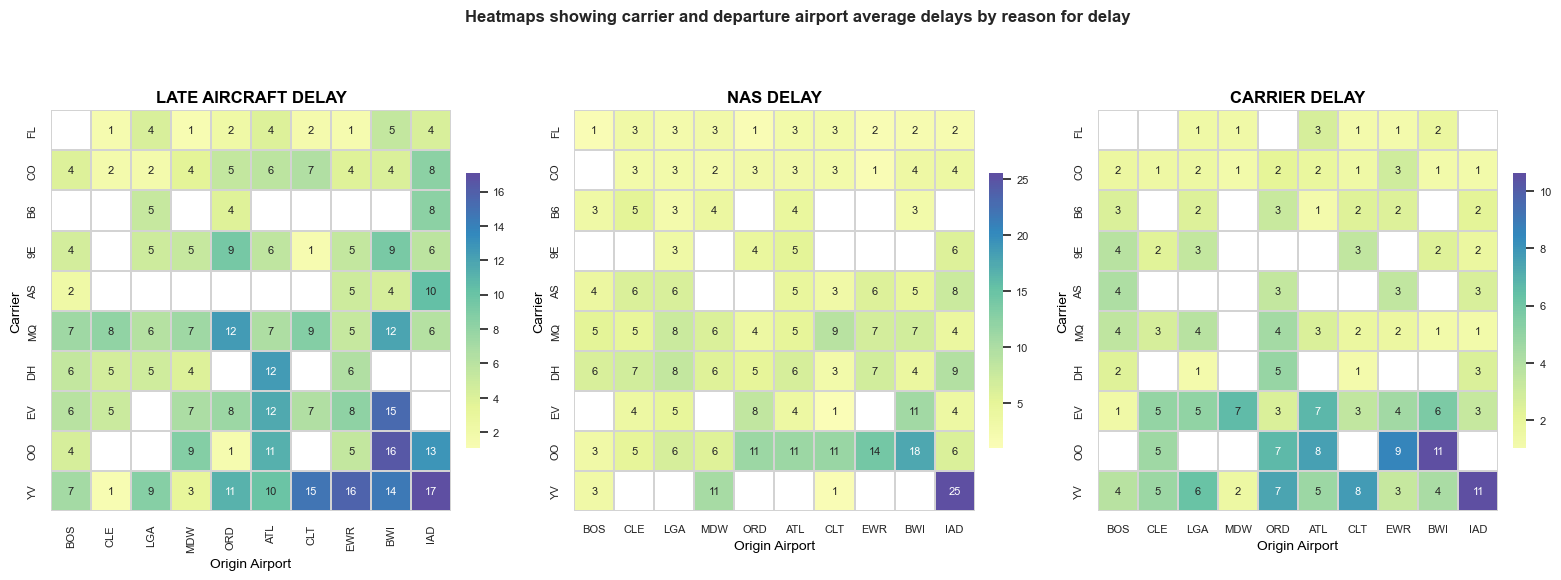

In [99]:
plt.figure(figsize = (16,6))

ax1 = plt.subplot(1,3,1)
vs.cat_heatmap(df_heatmap_lateAircraftDelay, reason='Late Aircraft Delay')

# add descriptions to xticks
xticks = ax1.get_xticks()
xlabels = []
locs, labels = plt.xticks()
for loc, label in zip(locs,labels):  
    city = '{}:{}'.format(label.get_text(), airports.loc[label.get_text()]['airport'][:20])
    xlabels.append(city)
plt.xticks(xticks, xlabels, rotation=90)

plt.subplot(1,3,2, sharey=ax1, sharex=ax1)
vs.cat_heatmap(df_heatmap_NASDelay, reason='NAS Delay')

plt.subplot(1,3,3, sharey=ax1, sharex=ax1)
vs.cat_heatmap(df_heatmap_carrierDelay, reason='Carrier Delay')

plt.suptitle('Heatmaps showing carrier and departure airport average delays by reason for delay')
plt.tight_layout()
plt.show()

>Similar results can be observed as in barchart above. Late aircraft have again a clear bottom right darker quadrant, similating our main heatplot.
>Carrier delay have a darker bottom quadrant in general, where YV, OO and EV have above average delays in all airports

<span style="color:blue; font-size:16px; font-family: Calibri;">**What is the time series pattern for the carriers and airports in the problem quadrant ?**</span>

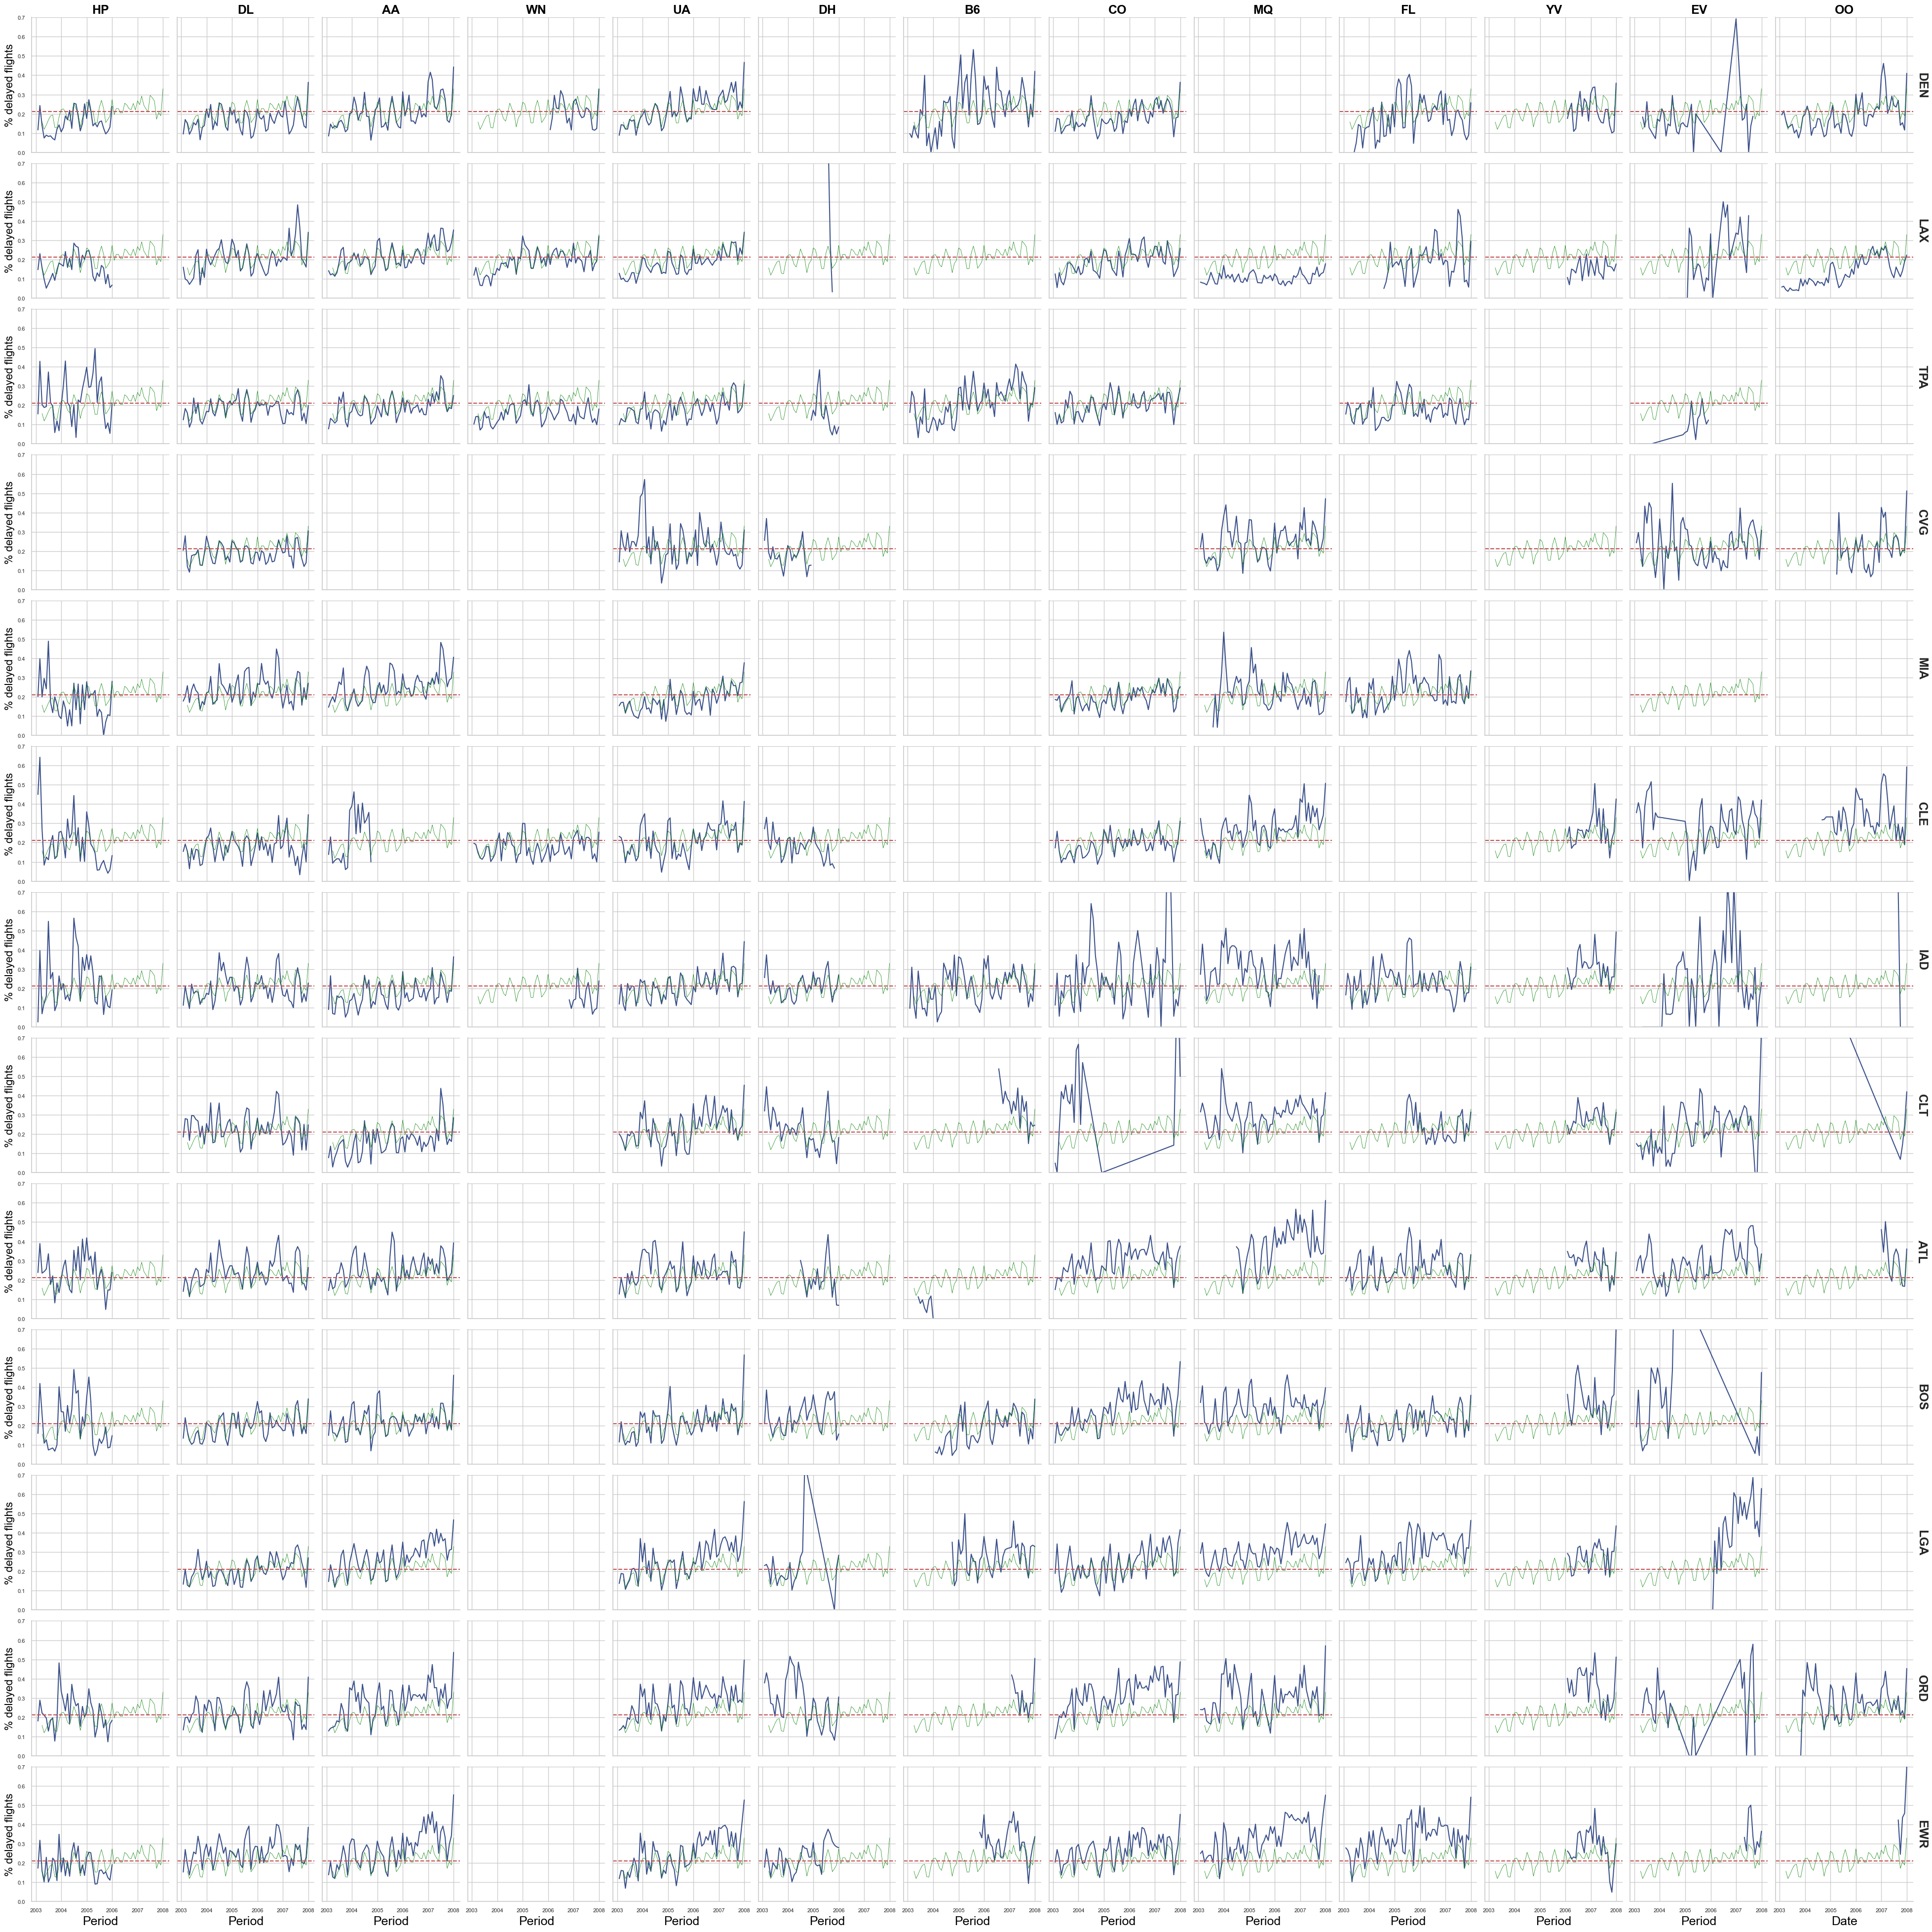

In [100]:
g = sns.FacetGrid(data=flight_timeseries_day_origin, col='uniqueCarrier', row='origin', margin_titles=True, ylim=(0, 0.7), 
                  row_order=problem_airport_best_worse, col_order=problem_carrier_best_worse)
g.map(sns.lineplot, 'date', 'prop', linewidth=1.5, color=BASE_COLOR)


g.map(sns.lineplot, data=flight_timeseries_month['prop'], color='green', linewidth=0.5)
g.refline(y=flight_timeseries_month["prop"].mean(), color='r')

# increase fonts of axis and labels
g.set_xlabels('Period', size=18)
g.set_ylabels('% delayed flights', size=16)

g.set_titles(col_template="{col_name}", row_template="{row_name}", fontweight='bold', size=18)
plt.ylabel('Number of delayed flights', fontsize=18)
plt.xlabel('Date', fontsize=18)

plt.show()

- EWR is doing consistantly worse overall, for good and bad carriers, always above the average delay mark
- ORD,LGA above average delays for all carriers
<!-- - LGA above average -->
- BOS does well for some carriers, but not for YV (biggest issue), MQ, CO
- ATL, CTL,CLE for carriers on right does worse, carriers on left is good
- IAD, carriers on right worse, left better. EV and CO consistently bad, 

Summary:
- For most airports, carriers on the left stick to average seasonal patterns, than carriers on the right at the same airport (eg. ATL, CTL, CLE)
- Carriers on the right YV, EV, FL have delays above average at all airports
- All carriers perform bad at EWR, ORD

- Avoid EWR, ORD if you can
- Avoid YV, EV, FL if you can

<span style="color:blue; font-size:16px; font-family: Calibri;">**Investigate the lanes for those carriers in the *problem* quadrand of the main heatmap above. Could it be that these carriers do multiple short haul flights, and a delay in one leg, cause delays for the rest of the day?**</span>

In [101]:
# get flights for the top 10 worse performing carriers, and selected carriers that is doing well overall as comparision
flight_stats = flights.loc[(flights['uniqueCarrier'].isin(problem_carrier_best_worse)) & (flights['origin'].isin(problem_airport_best_worse))]

In [172]:
# calculate the distance, number of flights and avg delay per lane/carrier
flight_stats2 = flight_stats.groupby(['origin', 'lane', 'uniqueCarrier'], as_index=False).agg(depDelay=('depDelay', np.mean),
                                                                                              arrDelay=('arrDelay', np.mean), 
                                                                                              nrFlights=('lane', np.size),
                                                                                              distance=('distance', np.mean),
                                                                                              taxiOut=('taxiOut', np.mean),
                                                                                              taxiIn=('taxiIn', np.mean))
# analyse only frequent flights
flight_stats2 = flight_stats2.loc[flight_stats2['nrFlights'] >= 300]
flight_stats2.head()

origin     lane uniqueCarrier   depDelay   arrDelay  nrFlights  nrRoutes  \
0    ATL  ATL-ABE            EV  18.549612  18.982262       3608         1   
1    ATL  ATL-ABQ            DL  11.791003  13.978645       5713         1   
2    ATL  ATL-ABY            EV  11.893011  12.787408       6496         1   
3    ATL  ATL-ACY            EV  22.381773  22.546799        812         1   
4    ATL  ATL-AEX            EV  17.904705  18.445927       4124         1   

   distance    taxiOut    taxiIn  
0     692.0  20.438471  4.442073  
1    1269.0  21.789078  6.716611  
2     146.0  19.210899  3.921952  
3     678.0  22.963055  4.156404  
4     500.0  21.165859  3.858390

In [103]:
# avg flights per day (fpd) per lane
flight_stats_fpd = flight_stats.groupby(['lane', 'uniqueCarrier', 'year', 'month', 'day'], as_index=False).size()
flight_stats_fpd['size'] = flight_stats_fpd['size'].round(0)
flight_stats_fpd = flight_stats_fpd.loc[flight_stats_fpd['size'] >= 1]
flight_stats_fpd = flight_stats_fpd.groupby(['lane', 'uniqueCarrier'], as_index=False).agg(dailyFlights=('size', np.mean))
flight_stats_fpd.head()

lane uniqueCarrier  dailyFlights
0  ATL-ABE            EV      2.348958
1  ATL-ABQ            DL      3.130411
2  ATL-ABY            EV      3.565313
3  ATL-ACY            EV      1.523452
4  ATL-AEX            EV      2.427310

In [104]:
flight_stats_final = pd.merge(flight_stats2, flight_stats_fpd, on=['lane', 'uniqueCarrier'], how='inner')
flight_stats_final.sort_values(by='dailyFlights', inplace=True)
flight_stats_final['dailyFlights'] = round(flight_stats_final['dailyFlights'],0)
flight_stats_final.head()

origin     lane uniqueCarrier   depDelay   arrDelay  nrFlights  distance  \
334     BOS  BOS-DEN            B6  16.165365  15.725337       1409    1754.0   
540     CVG  CVG-BNA            EV   8.002763   7.419889        362     230.0   
539     CVG  CVG-BNA            DL   6.340153   8.115089        782     230.0   
157     ATL  ATL-LAS            HP  16.730913  17.641527       1074    1747.0   
1069    LAX  LAX-BDL            DL   7.617188   9.160937        640    2527.0   

        taxiOut    taxiIn  dailyFlights  
334   16.204401  8.361959           1.0  
540   15.685082  5.450276           1.0  
539   16.052429  6.294117           1.0  
157   22.261639  6.898510           1.0  
1069  19.432812  9.345312           1.0

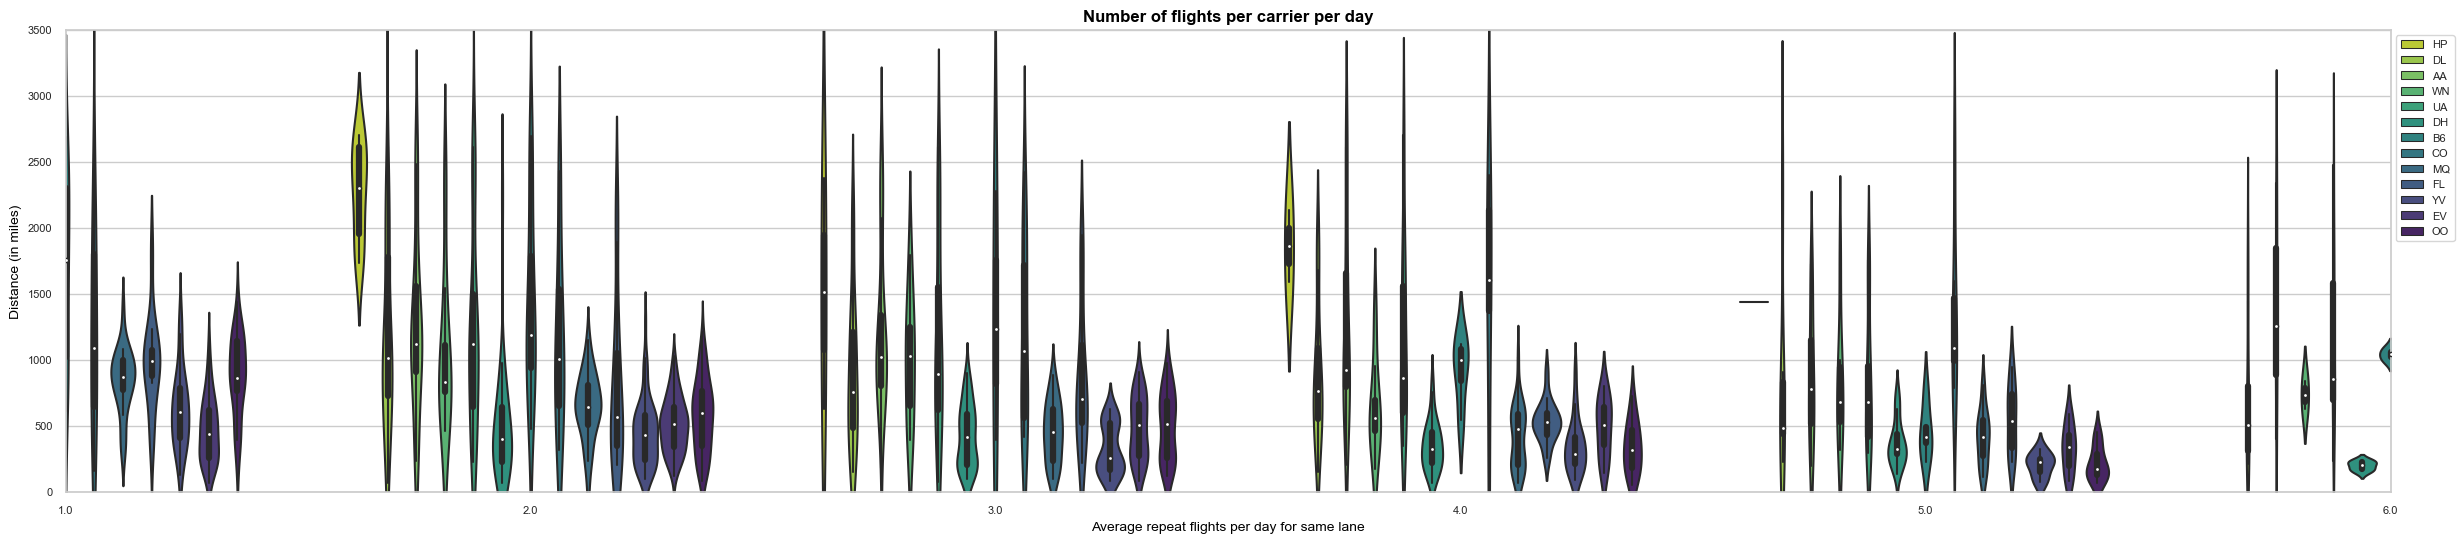

In [105]:
plt.figure(figsize = (30,6))
sns.violinplot(data=flight_stats_final, x='dailyFlights', y='distance', hue='uniqueCarrier', color=BASE_COLOR, palette='viridis_r', hue_order=problem_carrier_best_worse)
plt.xlim(0,5)
plt.ylim(0,3500)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
plt.title('Number of flights per carrier per day')
plt.ylabel('Distance (in miles)')
plt.xlabel('Average repeat flights per day for same lane')
plt.show()

> There are no differences in the number of repeat flights these carriers do per day, but there's a difference in the distance of those repeat flights. Overall, carriers on left of the problem quadrant are doing longer distances than the carriers on the right of them quadrant, especially for lanes with repeat flights 2-4 per day. Also, the  better carriers only do repeat flights, not single flights.

Let's confirm this findings in a bar chart for more clarity

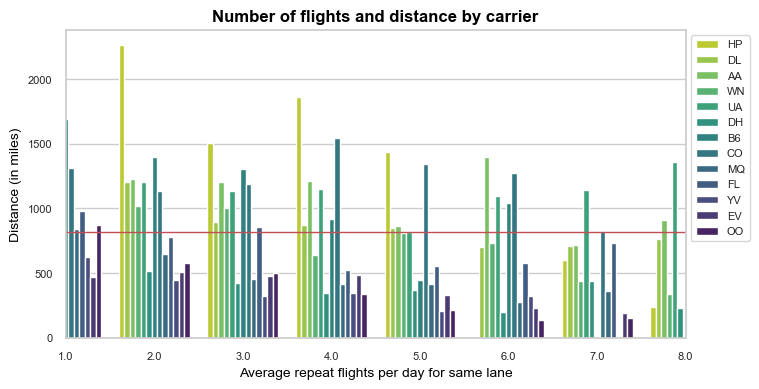

In [106]:
mean_distance = int(flight_stats_final['distance'].mean())

sns.barplot(data=flight_stats_final, x='dailyFlights', y='distance', hue='uniqueCarrier', linewidth=1, errorbar=None, hue_order=problem_carrier_best_worse, palette='viridis_r')
plt.axhline(y=mean_distance, color='r', linewidth=1)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
plt.xlim(0,7)

# min_xlim, max_xlim = plt.xlim()
# plt.text(max_xlim*0.85, mean_distance*1.01, 'Mean: {:.0f}'.format(mean_distance), weight='bold')

plt.title('Number of flights and distance by carrier')
plt.ylabel('Distance (in miles)')
plt.xlabel('Average repeat flights per day for same lane')
plt.show()

> We more clearly observe, carriers in the problem quadrant fly multiple but shorter distances <= 500 km, were carriers on the left of the quandrant, do distances near or above 1000 km

#### Observe the average flight distance per carrier

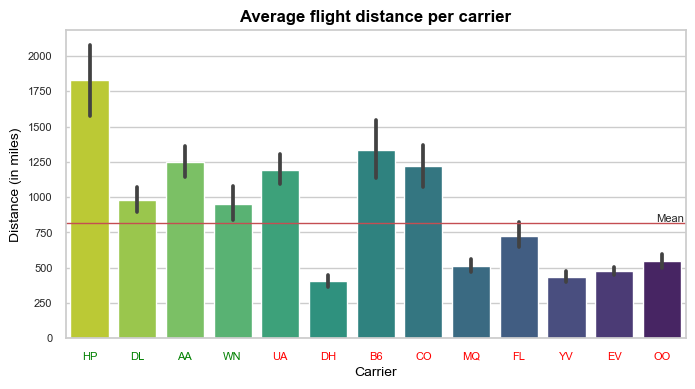

In [107]:
mean_distance = int(flight_stats_final['distance'].mean())
sns.barplot(data=flight_stats_final, x='uniqueCarrier', y='distance', order=problem_carrier_best_worse, palette='viridis_r')
plt.axhline(y=mean_distance, color='r', linewidth=1)

min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.95, mean_distance*1.01, 'Mean')

# indicate which carriers are performing above and below average by setting xtick label to green or red
for ax in plt.gca().get_xticklabels()[:4]:
    ax.set_color('green')
    
for ax in plt.gca().get_xticklabels()[4:]:
    ax.set_color('red')

plt.title('Average flight distance per carrier')
plt.ylabel('Distance (in miles)')
plt.xlabel('Carrier')
plt.show()

> Overall, carriers on the right fly distances below average of 816 km, whilst carriers on the left fly distances above average

#### Observe the average number of repeat flights per carrier

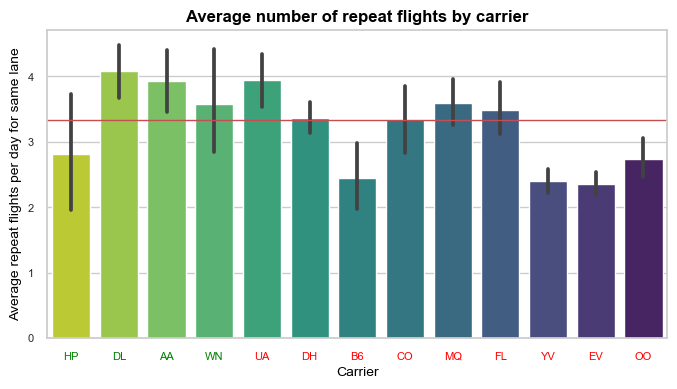

In [108]:
sns.barplot(data=flight_stats_final, x='uniqueCarrier', y='dailyFlights', order=problem_carrier_best_worse, palette='viridis_r')
plt.axhline(y=flight_stats_final['dailyFlights'].mean(), color='r', linewidth=1)
plt.title('Average number of repeat flights by carrier')
plt.ylabel('Average repeat flights per day for same lane')
plt.xlabel('Carrier')

# indicate which carriers are performing above and below average by setting xtick label to green or red
for ax in plt.gca().get_xticklabels()[:4]:
    ax.set_color('green')
    
for ax in plt.gca().get_xticklabels()[4:]:
    ax.set_color('red')
    
plt.show()

> Overall, carriers on the right fly less repeat flights than carriers on the left of the barplot. 

<blockquote>
    
**Summary of short vs long haul analysis:**
    
Carriers in the problem quadrant fly multiple repeat flights, but over shorter distances around 500 miles, whereas carriers on the left of the quandrant, do distances around 1000 miles
The distinquesing factor is **not** the number of flights per day, but the **distances** of those flights. Bigger airlines fly longer distances, and this have a bigger chance to catchup delays during the flight.
    
</blockquote>

#### Lastly, can we use taxiOut/taxiIn to see if smaller airlines have low priority at larger airports, e.g. departure from a gate vs parked and need to use bus to transport passengers?

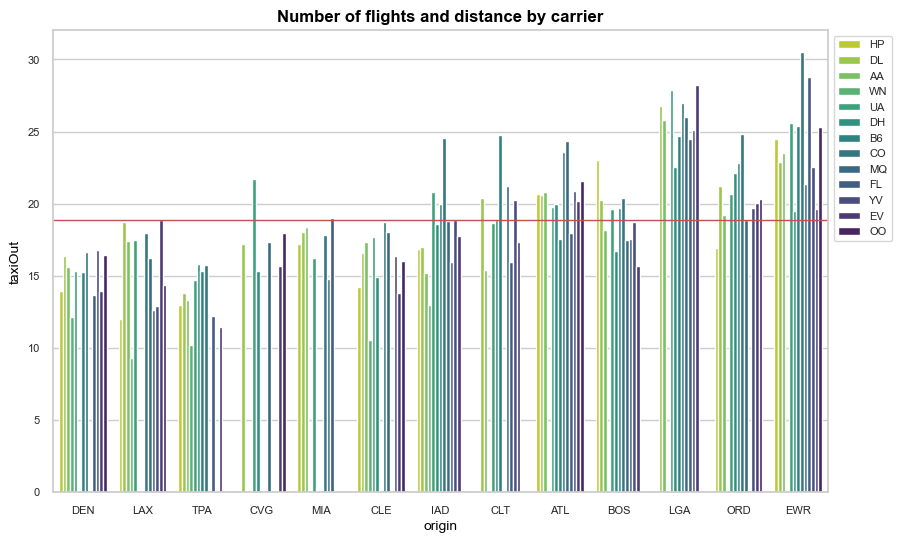

In [177]:
# Define figure
fig,ax = plt.subplots(figsize = (10,6))

sns.barplot(data=flight_stats_final, hue='uniqueCarrier', y='taxiOut', x='origin', order=problem_airport_best_worse, hue_order=problem_carrier_best_worse, 
            palette='viridis_r', errorbar=None)
plt.axhline(y=flight_stats_final['taxiOut'].mean(), color='r', linewidth=1)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') 
plt.title('Number of flights and distance by carrier')
plt.show()

>Airports on the right of the plot have larger average taxiOut times than those airports on the left. All carriers at the same airport have similar taxiOut times.
>Larger taxiOut seems to be a reflection on the airport and not the carrier. 

>Summary: We cannot use taxiOut to distinguise carriers, but we can use it to distinguish busy airports. Large taxiOut could indicate there are long to take-off, and shows it's a busy airport

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

<blockquote>

Possible reasons why carriers and/or airports combinations in the *problem* quadrant of the main heatmap in bivariate exploration have higher delays, are further explored. 
     
Several avenues were explored for carrier/origin airport relationships: seasonality fluctionals, reasons for delays, number of repeat flights per lane per day, distances of flights and taxiOut times.
    
We saw from bivariate exploration that we have an opportunity to catch-up delays, especially between 15-375 minutes air time
We observed carriers in the *problem* quadrant fly frequent but **shorter distances around 500 miles**, thus don't have much opportunity to catch-up delays over those carriers who fly **longer distances around 1000 miles**. Flight distance is the most distinguishing factor amongst carriers. 
    
    
</blockquote>

### Were there any interesting or surprising interactions between features?

> I am surprised how distance seems to be distinguishing factor that predicts how carriers cope with seasonal delays

<a id='conclusions'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Conclusions</span>

<blockquote>

**Appoach:**
    
- From univariate exploration, we know which airports and carriers experience the most delays.
- In bivariate exploration, I zoomed into the relationships between the top 30 airports and carriers experiencing the most delays, to identify if there are certain airports and carriers that should be specifially avoided. A *problem quadrant* was discovered, where a group of around 10-12 carrier/airport combinations, have above average delays.

- In multivariate exploration, we try to find the reasons for these above average delays in the *problem quadrant*.
To find possible distinguishing factors, 4 carriers that have consistent average delays accross all airports are compared with 8 carrier/airport combinations that have above average delays. These two groups are compared from various perspectives.

A divergent palette vidiris_r was used consistently, where yellow/light green is used to show average delays, and dark green/blue to show above average delays.

**Main findings:**
    
Around 77% of flights are on time, where as 21% are delayed. Only 2% of flights are cancelled or diverted which is not therefore not the main concern and were further excluded.
The top 3 reasons for delays are caused by late aircrafts (36%), NAS(32%), and carriers(26%).
Flights and delays increase every year, we see an upwards trend. We can therefore expect more delays in future during peak periods if this trend continues.

There is a strong seasonal pattern. There are 2 strong peaks, the biggest one around xmas time in December - March, and another one during summer months June - August.
Mondays, Thursdays and Fridays are the busiest times at airports, it is the most quiet on Tuesdays and Saturdays.
Delays grows progressively throughout the day, with most delays happening between 17:00-20:00   
    
The top busiest origin/departure airports (ATL, ORD, DFW and EWR) are also the top destination/arrival airports causing delays, meaning a delay in the origin is causing a delay in the destination. From a proportional perspective, JFK, PHL, EWR, ORD have over 40% of their flights delayed on departure, whilst EWR, LGA, ANC, JFK, ROC have the biggest delays at destination/arrival airports.
    
When a lane consist of a combination where both origin and destination airports are ORD, EWR, ATL, DFW, we can defintely expect delays.

There is not as much variation in the average total flights per month even in the peak periods, which suggest it's not the number of flights itself that are causing the problem. The delays happens in the peak seasons mostly during the week, which suggest the biggest driver for delays might be due to passenger throughput.
    
Main reasons for delays are late aircraft and carrier delays in origin airports. NAS delays happens mostly in destination airports, and are a consequence of delays that happened in origin airports. Destination airports have a tough time to reschedule late arriving flights especially in busy periods.
    
Of the top 30 carriers and airports causing the highest average delays, there is a specific combination of carriers/airports falling into the bottom right quadrant on the main heatmap, that cause higher that average delays. Carriers in the problem quadrant fly multiple repeat flights, but over shorter distances around 500 miles, whereas carriers on the left of the quandrant, do distances around 1000 miles. Carriers with shorter distances, have less time to catch-up any delays during flight time.
      
Avoid airports EWR, ORD, as all top carriers have above average delays at these airports
Avoid carriers YV, EV, FL, as they perform consistenly bad at all top airports                                                                                           
    
</blockquote>

<a id='references'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">References</span>

- [white text in pie chart](https://www.tutorialspoint.com/how-to-change-autopct-text-color-to-be-white-in-a-pie-chart-in-matplotlib)
- [interpretting acf and pacf graphs](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)
- [formating xaxis date labels](https://stackoverflow.com/questions/56638648/seaborn-barplot-and-formatting-dates-on-x-axis)
- [annotate barplot](https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/)
- [annoate barplot vertical vs horizontal](https://www.kaggle.com/code/asimislam/tutorial-annotate-placing-numbers-on-plots)
- [annotate plot with mean value](https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib)
- [A Little Bit Of Extra Effort Can Hugely Transform Your Basic Matplotlib Plots](https://github.com/ChawlaAvi/Daily-Dose-of-Data-Science/blob/main/Plotting/Professional-Plots-With-Matplotlib.ipynb?utm_source=substack&utm_medium=email)

<a id='submission'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Submission</span>

In [110]:
# convert notebook to html
os.system('jupyter nbconvert --to html Part_II_exploration.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook Part_II_exploration.ipynb to html
[NbConvertApp] Writing 6220677 bytes to Part_II_exploration.html


0